# seeing how these models do on RNA seq

In [1]:
#we have the results form borzoi and this model, let's correlate and evaluate!

import numpy as np
import zarr

root = zarr.open('/data1/lesliec/sarthak/data/borzoi/model_outputs_fold3.zarr', mode='r')
root.tree()

/
└── fold3 (6888, 6144, 7611) float16

In [2]:
#now let's load in the numpy array
joint = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_RNA_predictions.npy')
targets = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_RNA_targets.npy')
joint.shape, targets.shape

((6888, 6144, 30), (6888, 6144, 30))

In [3]:
import json
json_file = '/data1/lesliec/sarthak/data/DK_zarr/idx_lists/gm12878_RNA.json'
with open(json_file) as f:
    idx = json.load(f)
idx

[870,
 871,
 6112,
 6113,
 6114,
 6115,
 6116,
 6117,
 6118,
 6119,
 6120,
 6121,
 6204,
 6205,
 6206,
 6207,
 6242,
 6243,
 6326,
 6327,
 6340,
 6434,
 6514,
 6515,
 6668,
 6669,
 7306,
 7307,
 7334,
 7394]

In [4]:
borzoi = root['fold3'][:,:,np.array(idx)]

In [5]:
borzoi.shape

(6888, 6144, 30)

In [6]:
borzoi.nbytes/1e9

2.53919232

In [7]:
joint.nbytes/1e9

10.15676928

In [8]:
borzoi.dtype

dtype('float16')

In [9]:
joint.dtype

dtype('float64')

In [ ]:
#well that would explain the difference lol. It's fine let's evaluate!

In [ ]:
#let's loop through and create them
#this will be incredibly slow, we can simply call rank data then pearson 
from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr

spearman_borzoi = np.zeros((borzoi.shape[0], borzoi.shape[2]))
spearman_joint = np.zeros((joint.shape[0], joint.shape[2]))
pearson_borzoi = np.zeros((borzoi.shape[0], borzoi.shape[2]))
pearson_joint = np.zeros((joint.shape[0], joint.shape[2]))

for i in tqdm(range(borzoi.shape[0])):
    for j in range(borzoi.shape[2]):
        spearman_borzoi[i,j] = spearmanr(borzoi[i,:,j], targets[i,:])[0]
        pearson_borzoi[i,j] = pearsonr(borzoi[i,:,j], targets[i,:])[0]
        spearman_joint[i,j] = spearmanr(joint[i,:,j], targets[i,:])[0]
        pearson_joint[i,j] = pearsonr(joint[i,:,j], targets[i,:])[0]

In [10]:
#let's precompute the ranks
from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr, rankdata

ranked_borzoi = np.apply_along_axis(rankdata, 1, borzoi)  # rank across axis=1 (6144)
ranked_joint  = np.apply_along_axis(rankdata, 1, joint)
ranked_targets = np.apply_along_axis(rankdata, 1, targets)
print(ranked_borzoi.shape, ranked_joint.shape, ranked_targets.shape)

(6888, 6144, 30) (6888, 6144, 30) (6888, 6144, 30)


In [20]:
#now evaluate!
spearman_borzoi = np.zeros((borzoi.shape[0], borzoi.shape[2]))
spearman_joint = np.zeros((joint.shape[0], joint.shape[2]))
pearson_borzoi = np.zeros((borzoi.shape[0], borzoi.shape[2]))
pearson_joint = np.zeros((joint.shape[0], joint.shape[2]))

for i in tqdm(range(borzoi.shape[0])):
    x_borzoi = borzoi[i]       # shape (6144, 30)
    x_joint = joint[i]         # shape (6144, 30)
    y = targets[i]             # shape (6144,)

    rx_borzoi = ranked_borzoi[i]
    rx_joint  = ranked_joint[i]
    ry        = ranked_targets[i]

    # now vectorized correlation over 30 targets

    for j in range(borzoi.shape[2]):
        spearman_borzoi[i,j] = pearsonr(rx_borzoi[:,j], ry[:,j])[0]
        pearson_borzoi[i,j] = pearsonr(x_borzoi[:,j], y[:,j])[0]
        spearman_joint[i,j] = pearsonr(rx_joint[:,j], ry[:,j])[0]
        pearson_joint[i,j] = pearsonr(x_joint[:,j], y[:,j])[0]

  0%|          | 0/6888 [00:00<?, ?it/s]/data1/lesliec/sarthak/caduceus/.pixi/envs/default/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 6888/6888 [08:07<00:00, 14.12it/s]


In [15]:
x_borzoi.shape

(6144, 30)

In [17]:
y.shape

(6144, 30)

In [19]:
pearsonr(rx_borzoi[:,j], ry[:,j])

PearsonRResult(statistic=0.20479158398324254, pvalue=3.5680367867172035e-59)

In [ ]:
#see how many nans we have
pearson_borzoi_isnan = np.isnan(pearson_borzoi).sum()
pearson_joint_isnan = np.isnan(pearson_joint).sum()
spearman_borzoi_isnan = np.isnan(spearman_borzoi).sum()
spearman_joint_isnan = np.isnan(spearman_joint).sum()
print(f'pearson_borzoi_isnan: {pearson_borzoi_isnan}, pearson_joint_isnan: {pearson_joint_isnan}, spearman_borzoi_isnan: {spearman_borzoi_isnan}, spearman_joint_isnan: {spearman_joint_isnan}')
print(f'numel in perason borzoi: {pearson_borzoi.size}') #seems some elements in targets must be 0?

pearson_borzoi_isnan: 17106, pearson_joint_isnan: 17106, spearman_borzoi_isnan: 17106, spearman_joint_isnan: 17106
numel in perason borzoi: 206640


In [28]:
#now let's see the values
#first set any nans to 0
spearman_borzoi[np.isnan(spearman_borzoi)] = 0
spearman_joint[np.isnan(spearman_joint)] = 0
pearson_borzoi[np.isnan(pearson_borzoi)] = 0
pearson_joint[np.isnan(pearson_joint)] = 0

In [31]:
#now let's compare it
pearson_borzoi.mean(0)

array([0.59560416, 0.5815832 , 0.30379679, 0.29604512, 0.30761134,
       0.3037094 , 0.31741041, 0.31129425, 0.3037079 , 0.29940779,
       0.35106318, 0.37450312, 0.35869567, 0.34885192, 0.35771212,
       0.35068334, 0.36629539, 0.35495817, 0.33668321, 0.32497505,
       0.41045595, 0.35261476, 0.29932131, 0.291042  , 0.26771069,
       0.28453113, 0.30719303, 0.29945287, 0.37969406, 0.37750677])

In [32]:
pearson_joint.mean(0)

array([0.5697297 , 0.56056007, 0.27853954, 0.27614481, 0.27856172,
       0.27594253, 0.29327058, 0.29177315, 0.26910366, 0.26613097,
       0.3093579 , 0.3182945 , 0.30862966, 0.30454511, 0.31399639,
       0.31149815, 0.3302986 , 0.32326726, 0.31688816, 0.31781531,
       0.36071716, 0.31209367, 0.27767465, 0.27354298, 0.24920059,
       0.25803441, 0.27712828, 0.27335754, 0.3339972 , 0.33307075])

In [33]:
spearman_borzoi.mean(0)

array([0.24296774, 0.24132972, 0.22837204, 0.21981068, 0.19186967,
       0.18714062, 0.24313024, 0.2355835 , 0.18390105, 0.17909613,
       0.22538366, 0.20966023, 0.2545642 , 0.24395621, 0.20934023,
       0.20194325, 0.29834124, 0.28414762, 0.29043212, 0.27799552,
       0.26022706, 0.20291741, 0.19794073, 0.18777329, 0.12603654,
       0.13090384, 0.20588019, 0.19678072, 0.23539111, 0.23591371])

In [35]:
spearman_joint.mean(0)

array([0.24004531, 0.23967727, 0.22046773, 0.21458021, 0.18291081,
       0.17959945, 0.23561105, 0.23227224, 0.17389587, 0.1711638 ,
       0.21503572, 0.19709047, 0.23664745, 0.23006299, 0.19818348,
       0.19305702, 0.28078407, 0.26953781, 0.27444648, 0.27388972,
       0.23937532, 0.18734431, 0.19255629, 0.18647508, 0.12197611,
       0.12535103, 0.19708159, 0.19165447, 0.22107624, 0.22120944])

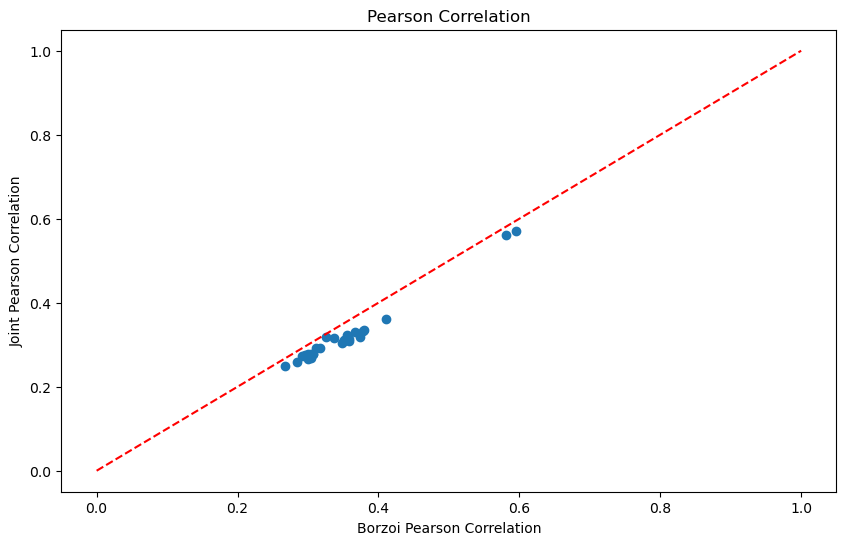

In [39]:
#let's do a scatter plot of these!

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(pearson_borzoi.mean(0), pearson_joint.mean(0))
plt.xlabel('Borzoi Pearson Correlation')
plt.ylabel('Joint Pearson Correlation')
plt.title('Pearson Correlation')
#and do the y=x line
plt.plot([0, 1], [0, 1], 'r--')

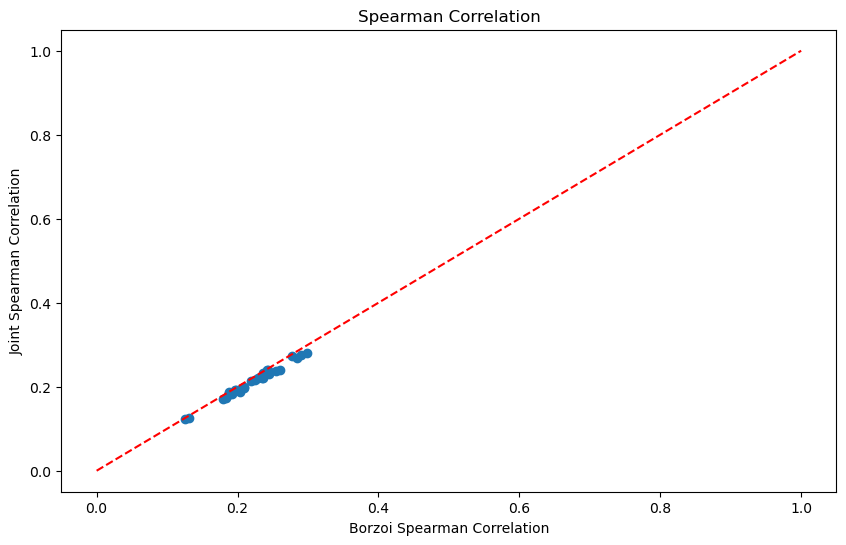

In [40]:
#and let's do spearman
plt.figure(figsize=(10, 6))
plt.scatter(spearman_borzoi.mean(0), spearman_joint.mean(0))
plt.xlabel('Borzoi Spearman Correlation')
plt.ylabel('Joint Spearman Correlation')
plt.title('Spearman Correlation')
#and do the y=x line
plt.plot([0, 1], [0, 1], 'r--')

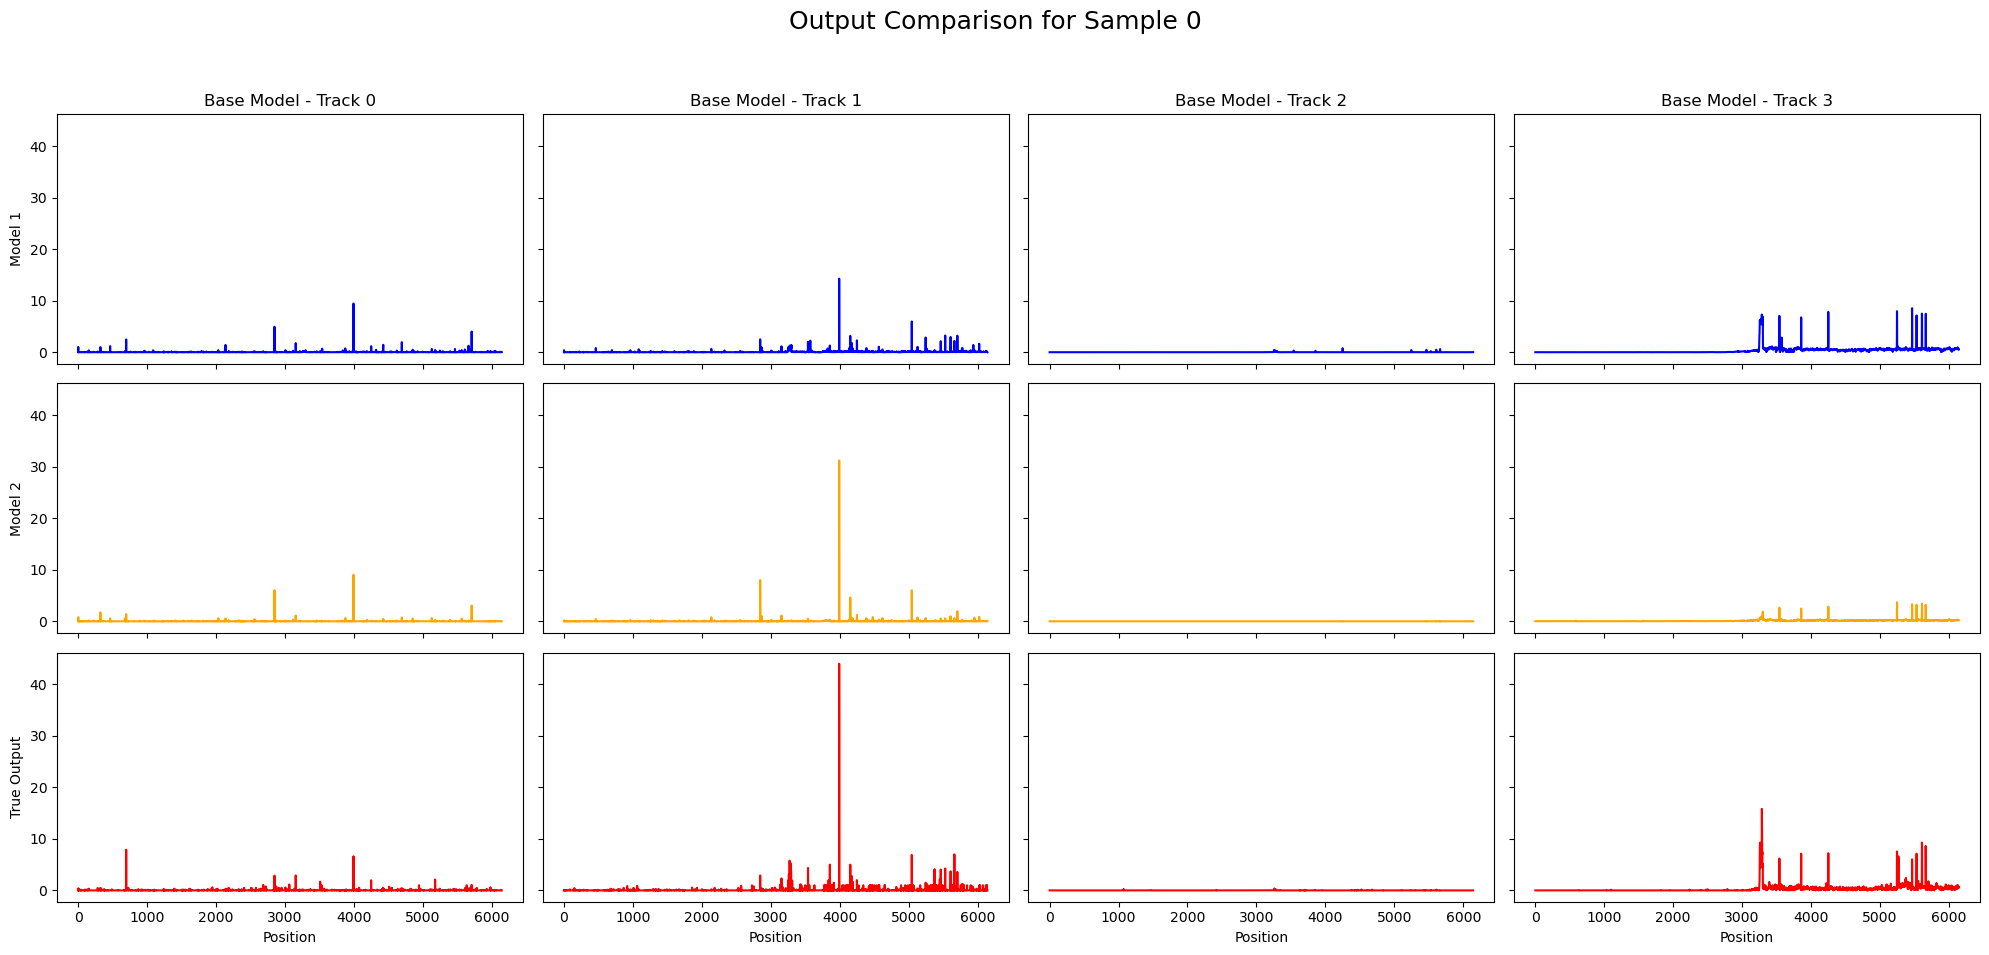

In [41]:
#let's look at some examples!

import matplotlib.pyplot as plt
import numpy as np

def plot_output_tracks(idx, model1_outputs, model2_outputs, true_outputs, track_indices):
    """
    Plots selected output tracks from two models and the true outputs.
    
    Parameters:
    - idx: integer, which sample to plot.
    - model1_outputs: (num_samples, output_length, num_tracks)
    - model2_outputs: (num_samples, output_length, num_tracks)
    - true_outputs: (num_samples, output_length, num_tracks)
    - track_indices: list of 4 integers, which tracks to plot.
    """

    positions = np.arange(model1_outputs.shape[1])

    fig, axes = plt.subplots(3, 4, figsize=(20, 10), sharex=True, sharey=True)

    for col, track_idx in enumerate(track_indices):
        # Row 0: Model 1
        axes[0, col].plot(positions, model1_outputs[idx, :, track_idx], color='blue')
        axes[0, col].set_title(f"Base Model - Track {track_idx}")
        if col == 0:
            axes[0, col].set_ylabel('Model 1')

        # Row 1: Model 2
        axes[1, col].plot(positions, model2_outputs[idx, :, track_idx], color='orange')
        if col == 0:
            axes[1, col].set_ylabel('Model 2')

        # Row 2: True Output
        axes[2, col].plot(positions, true_outputs[idx, :, track_idx], color='red')
        if col == 0:
            axes[2, col].set_ylabel('True Output')
        axes[2, col].set_xlabel('Position')

    fig.suptitle(f"Output Comparison for Sample {idx}", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_output_tracks(0, borzoi, joint, targets, [0, 1, 2, 3])

In [42]:
idx

[870,
 871,
 6112,
 6113,
 6114,
 6115,
 6116,
 6117,
 6118,
 6119,
 6120,
 6121,
 6204,
 6205,
 6206,
 6207,
 6242,
 6243,
 6326,
 6327,
 6340,
 6434,
 6514,
 6515,
 6668,
 6669,
 7306,
 7307,
 7334,
 7394]

In [46]:
#let's get the track names
import pandas as pd
target_csv = pd.read_csv('/data1/lesliec/sarthak/data/DK_zarr/targets_borzoi.txt', sep='\t', index_col=0)
target_csv
# target_csv.iloc[-1,idx]

,identifier,file,clip,clip_soft,scale,sum_stat,strand_pair,description
0,CNhs10608+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.00,sum,1,CAGE:Clontech Human Universal Reference Total ...
1,CNhs10608-,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.00,sum,0,CAGE:Clontech Human Universal Reference Total ...
2,CNhs10610+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.00,sum,3,CAGE:SABiosciences XpressRef Human Universal T...
3,CNhs10610-,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.00,sum,2,CAGE:SABiosciences XpressRef Human Universal T...
4,CNhs10612+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.00,sum,5,CAGE:Universal RNA - Human Normal Tissues Bioc...
...,...,...,...,...,...,...,...,...
7606,GTEX-13FTX-1026-SM-5J2O5.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.01,sum_sqrt,7606,RNA:uterus
7607,GTEX-1MA7W-1526-SM-DHXKS.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.01,sum_sqrt,7607,RNA:uterus
7608,GTEX-11EMC-1926-SM-5A5JU.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.01,sum_sqrt,7608,RNA:vagina
7609,GTEX-12WSB-2426-SM-5EGJC.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.01,sum_sqrt,7609,RNA:vagina


In [49]:
track_names = target_csv['description'].values[idx]

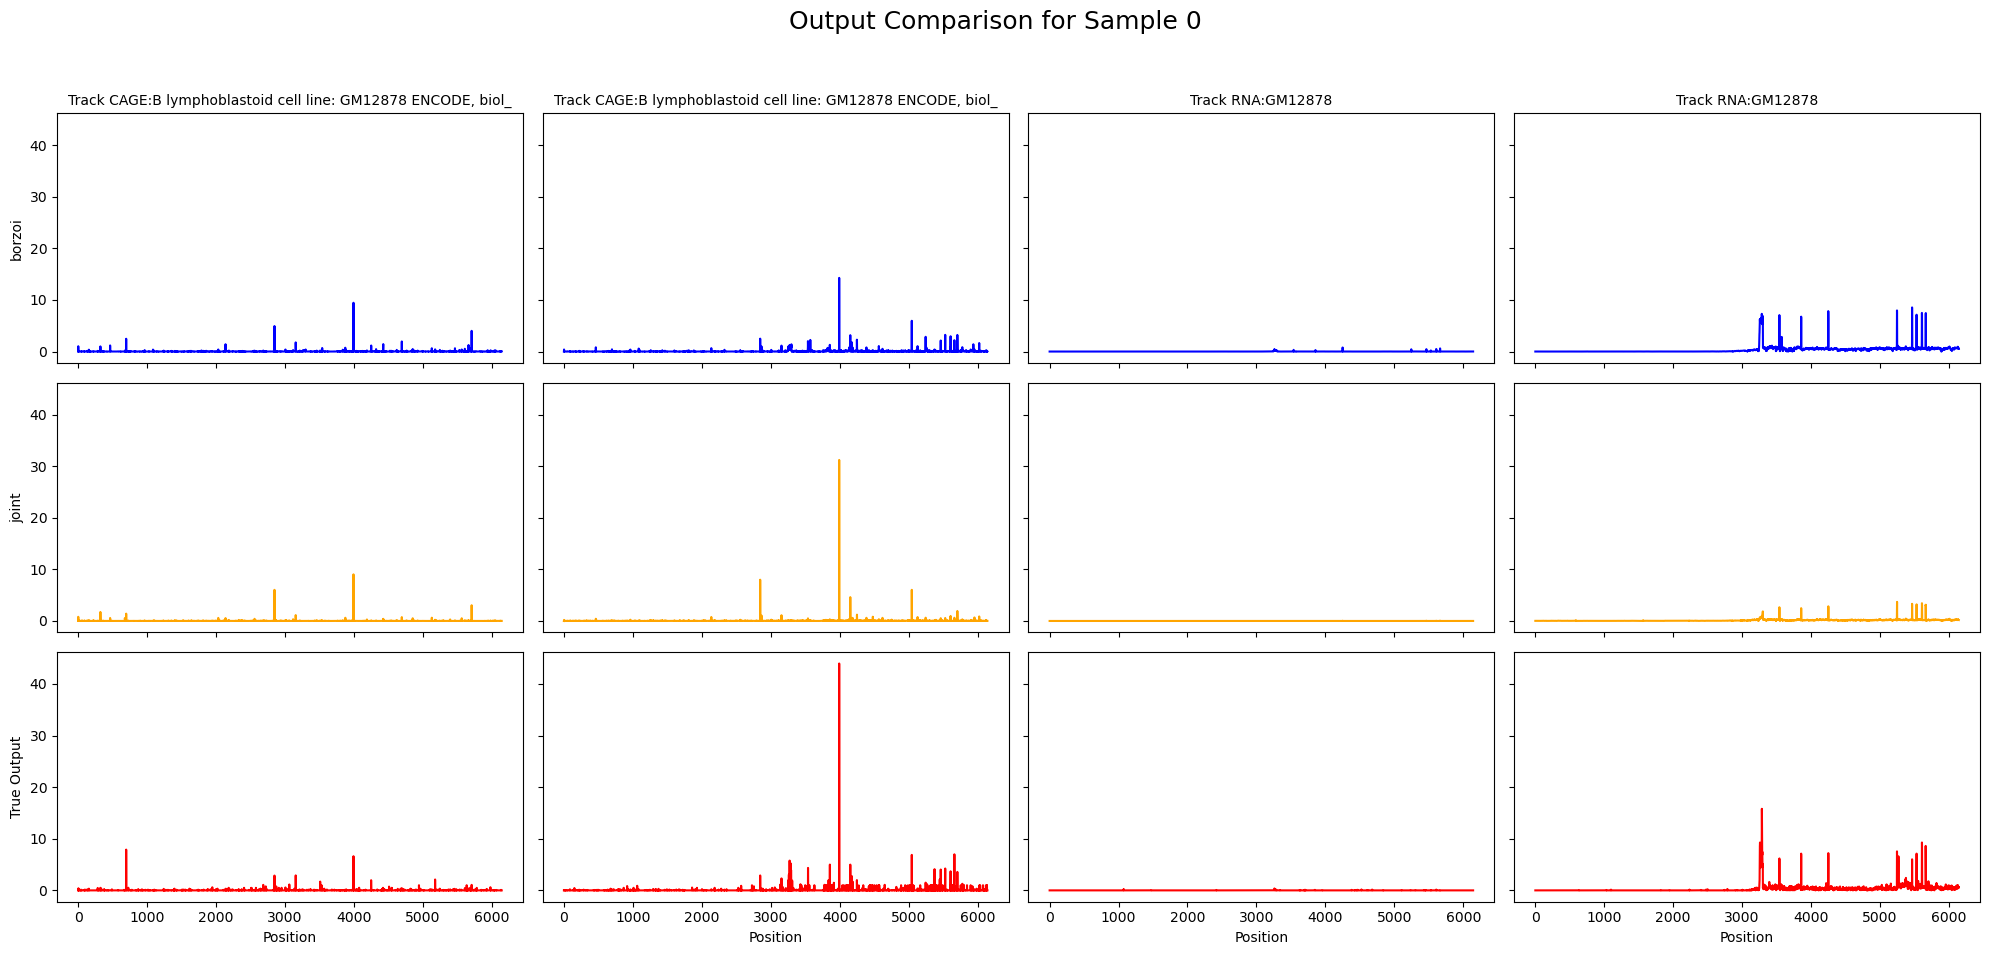

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def plot_output_tracks(idx, model1_outputs, model2_outputs, true_outputs, track_indices):
    """
    Plots selected output tracks from two models and the true outputs.
    
    Parameters:
    - idx: integer, which sample to plot.
    - model1_outputs: (num_samples, output_length, num_tracks)
    - model2_outputs: (num_samples, output_length, num_tracks)
    - true_outputs: (num_samples, output_length, num_tracks)
    - track_indices: list of 4 integers, which tracks to plot.
    """

    positions = np.arange(model1_outputs.shape[1])

    fig, axes = plt.subplots(3, 4, figsize=(20, 10), sharex=True, sharey=True)

    for col, track_idx in enumerate(track_indices):
        # Row 0: Model 1
        axes[0, col].plot(positions, model1_outputs[idx, :, track_idx], color='blue')
        axes[0, col].set_title(f"Track {track_names[track_idx]}", fontsize=10)
        if col == 0:
            axes[0, col].set_ylabel('borzoi')

        # Row 1: Model 2
        axes[1, col].plot(positions, model2_outputs[idx, :, track_idx], color='orange')
        if col == 0:
            axes[1, col].set_ylabel('joint')

        # Row 2: True Output
        axes[2, col].plot(positions, true_outputs[idx, :, track_idx], color='red')
        if col == 0:
            axes[2, col].set_ylabel('True Output')
        axes[2, col].set_xlabel('Position')

    fig.suptitle(f"Output Comparison for Sample {idx}", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_output_tracks(0, borzoi, joint, targets, [0, 1, 2, 3])

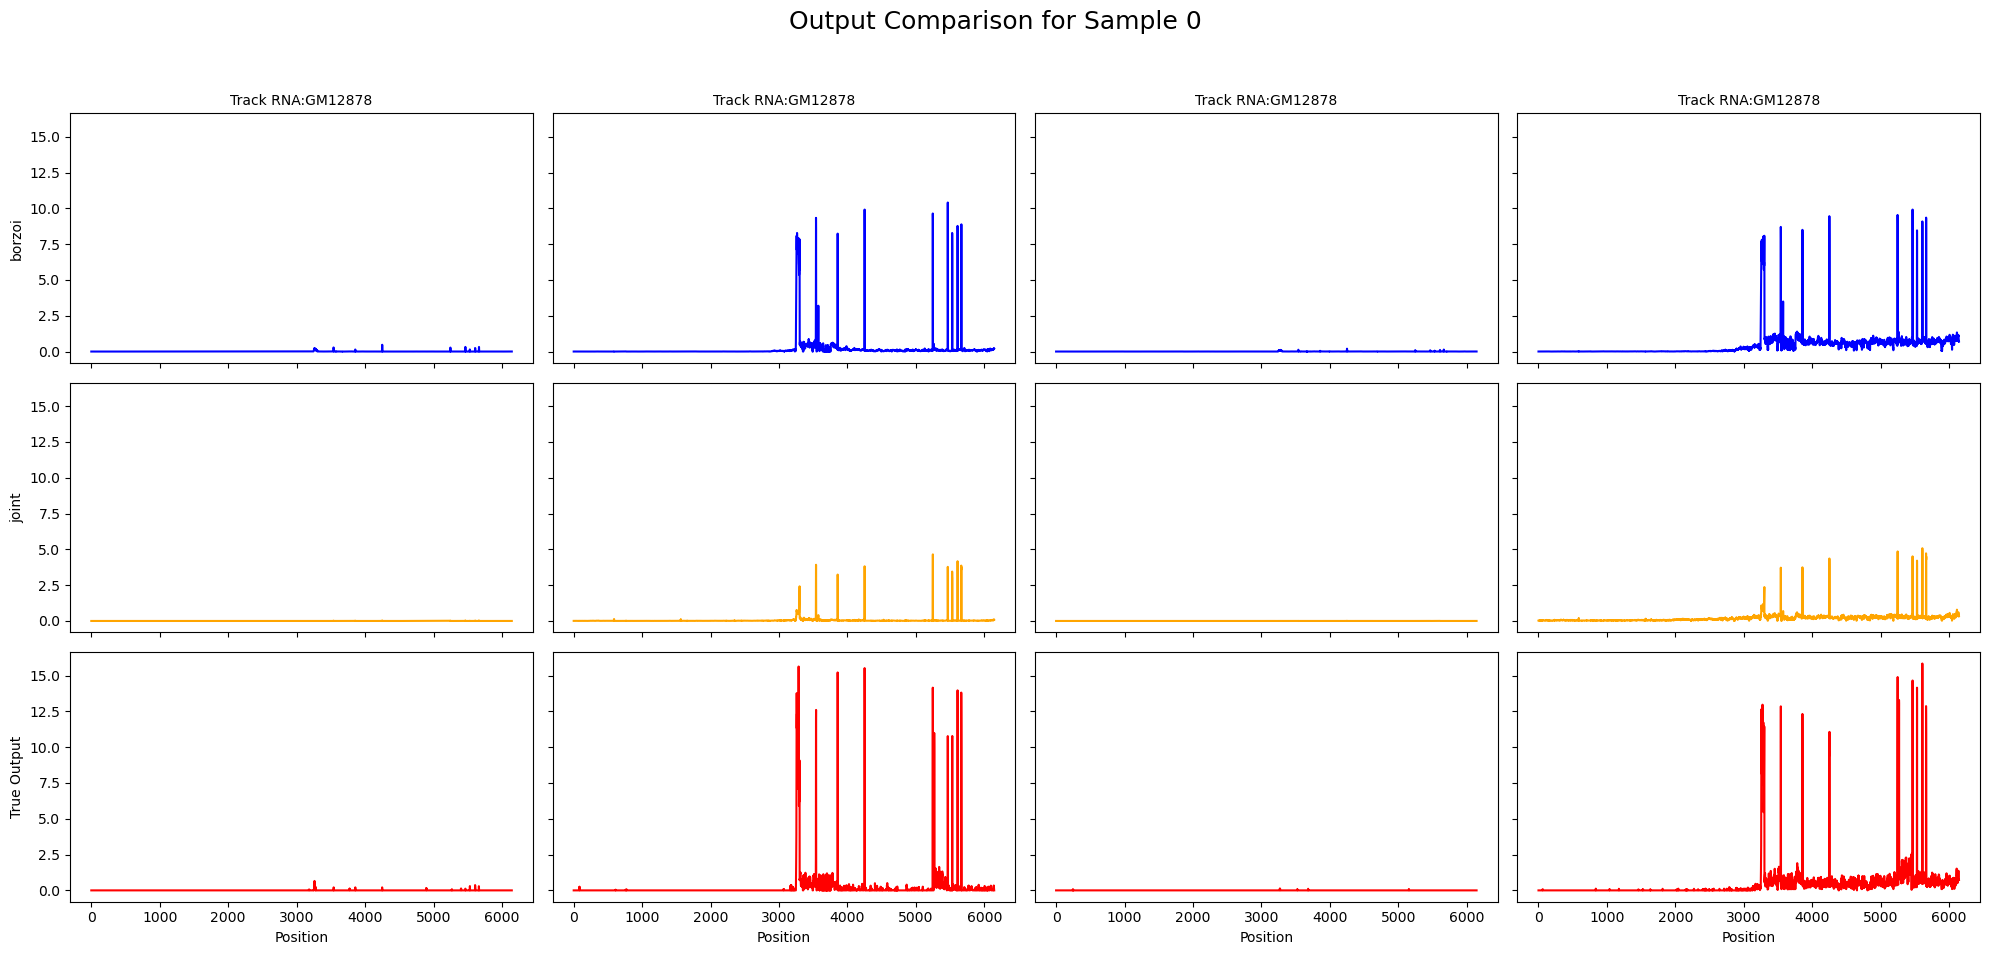

In [55]:
plot_output_tracks(0, borzoi, joint, targets, [4,5,6,7])

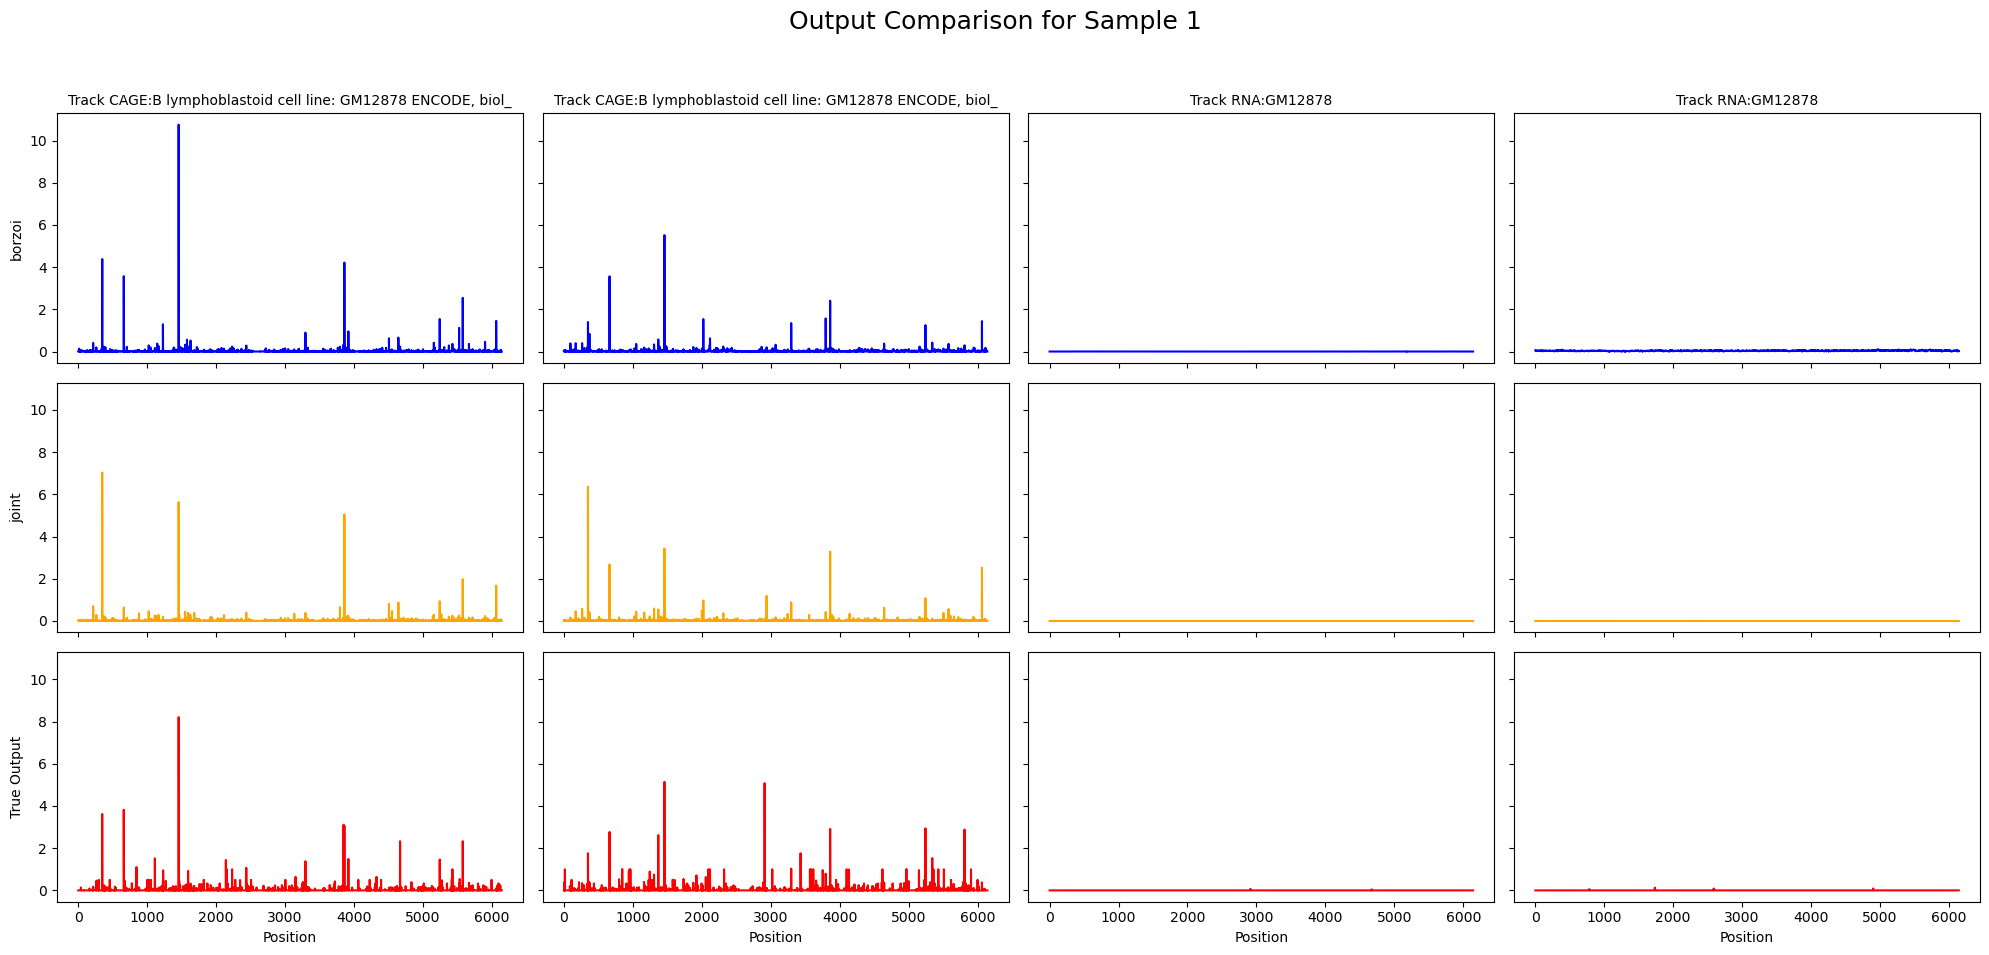

In [56]:
plot_output_tracks(1, borzoi, joint, targets, [0, 1, 2, 3])

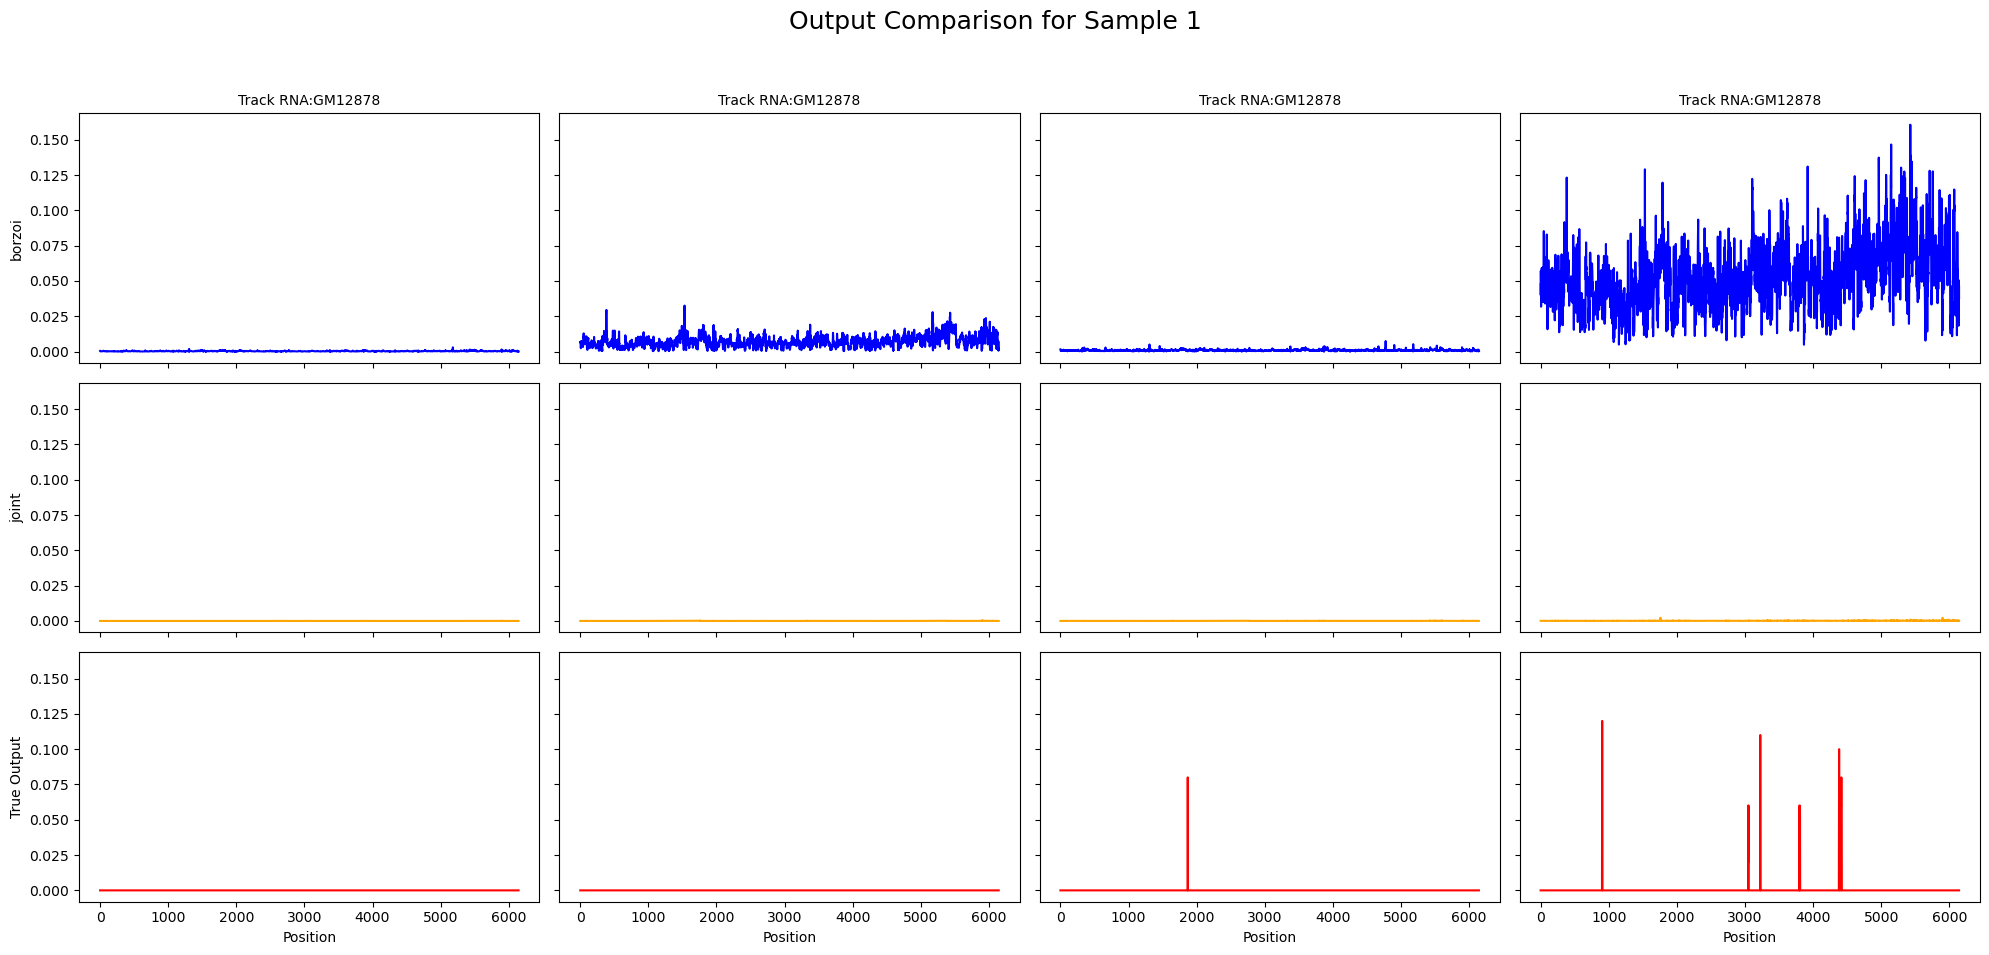

In [57]:
plot_output_tracks(1, borzoi, joint, targets, [4,5,6,7])

In [62]:
#let's find largest values of RNA
targets.shape

(6888, 6144, 30)

In [67]:
temp = targets[:,:,2]
temp.max(1)

array([ 0.37011719,  0.04998779, 19.296875  , ...,  8.6015625 ,
        0.10998535,  0.18994141])

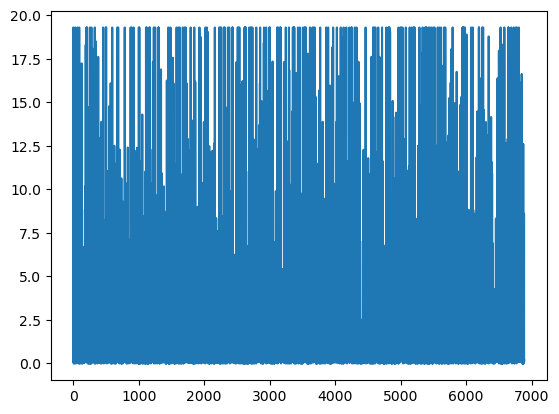

In [69]:
plt.plot(temp.max(1))

In [72]:
temp.max(1)[:50]

array([ 0.37011719,  0.04998779, 19.296875  ,  0.31005859,  0.08001709,
        4.078125  ,  0.33007812,  0.72021484,  2.83984375,  0.08001709,
        0.        ,  3.33984375,  0.04998779,  3.3203125 ,  0.07000732,
        0.25      ,  0.18994141,  0.17004395,  0.16003418,  0.23999023,
        0.        ,  0.20996094,  0.27001953,  0.08001709,  0.29003906,
        0.15002441,  1.45019531,  1.53027344,  0.25      , 19.296875  ,
        0.29003906,  0.2199707 ,  0.16003418, 10.2890625 ,  5.94140625,
        0.2800293 ,  6.3203125 ,  0.08001709,  0.2800293 ,  2.38085938,
        0.        ,  0.02999878,  0.08001709,  0.18005371,  0.04998779,
       15.2734375 ,  0.23999023,  0.11999512,  0.13000488,  4.76171875])

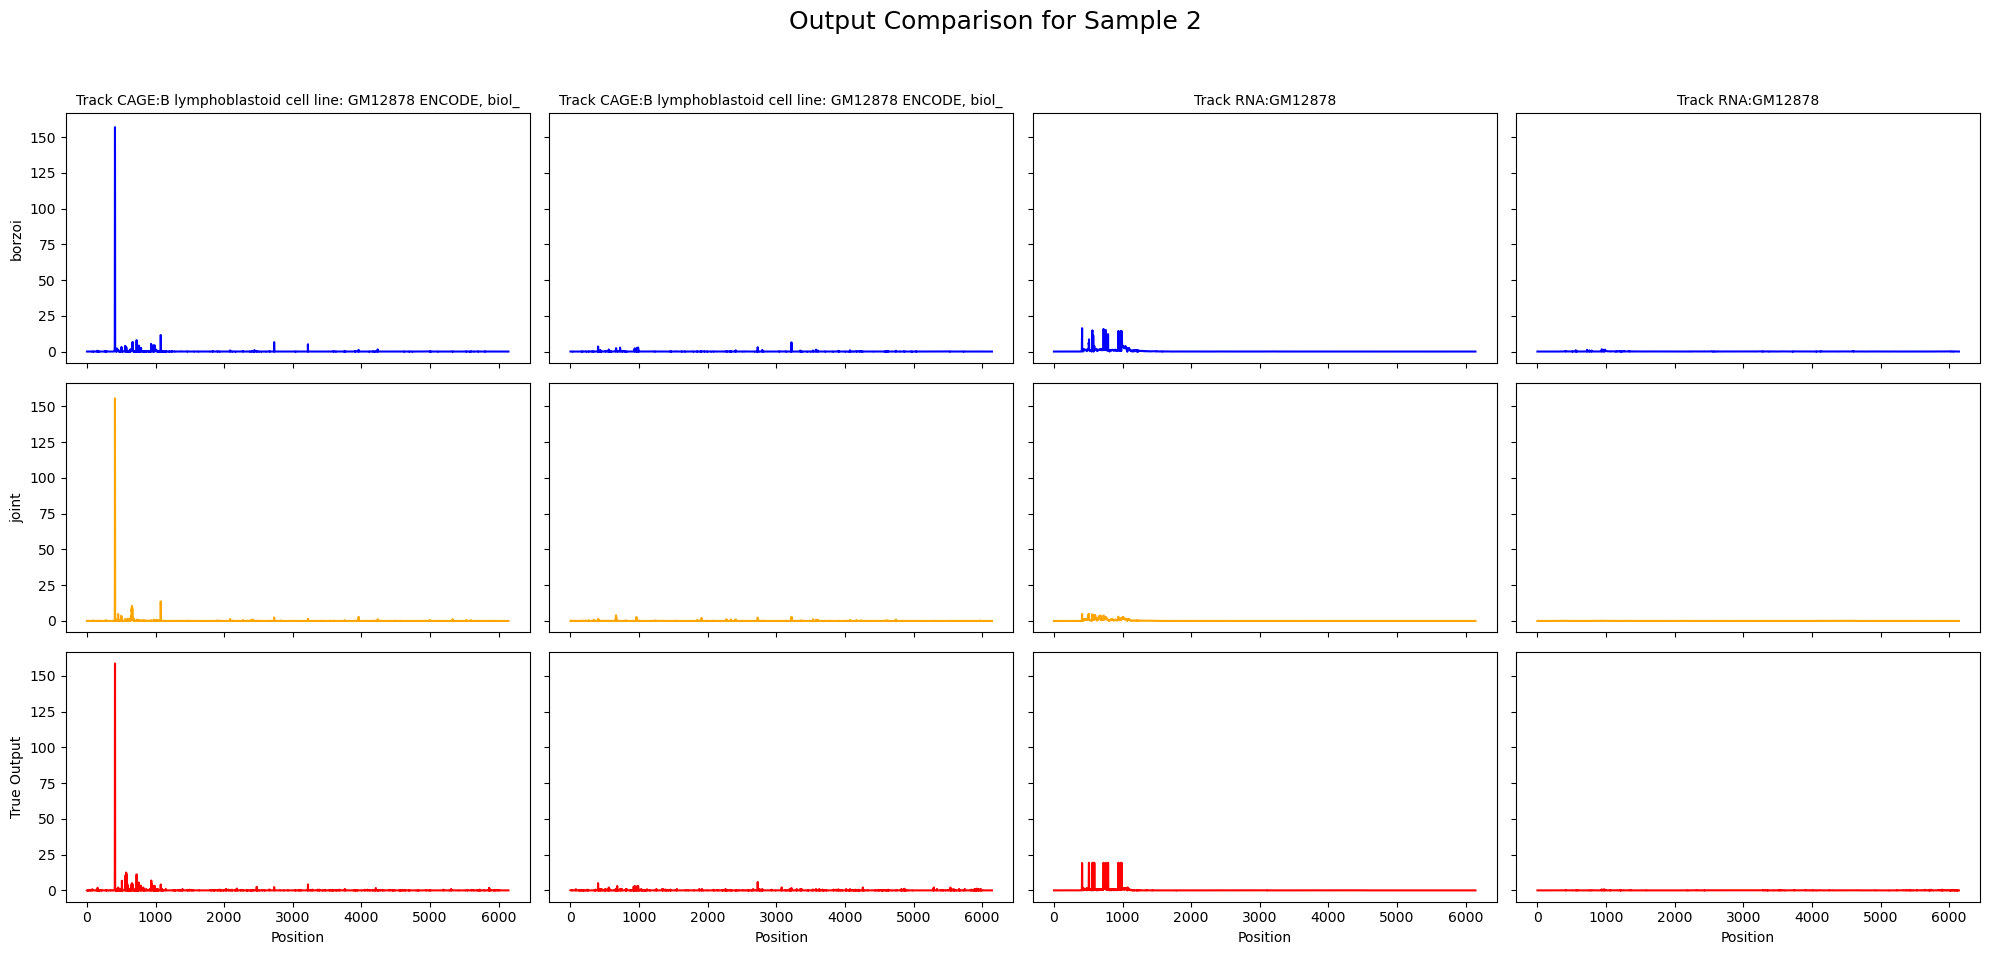

In [68]:
#2 is good lol
plot_output_tracks(2, borzoi, joint, targets, [0, 1, 2, 3])

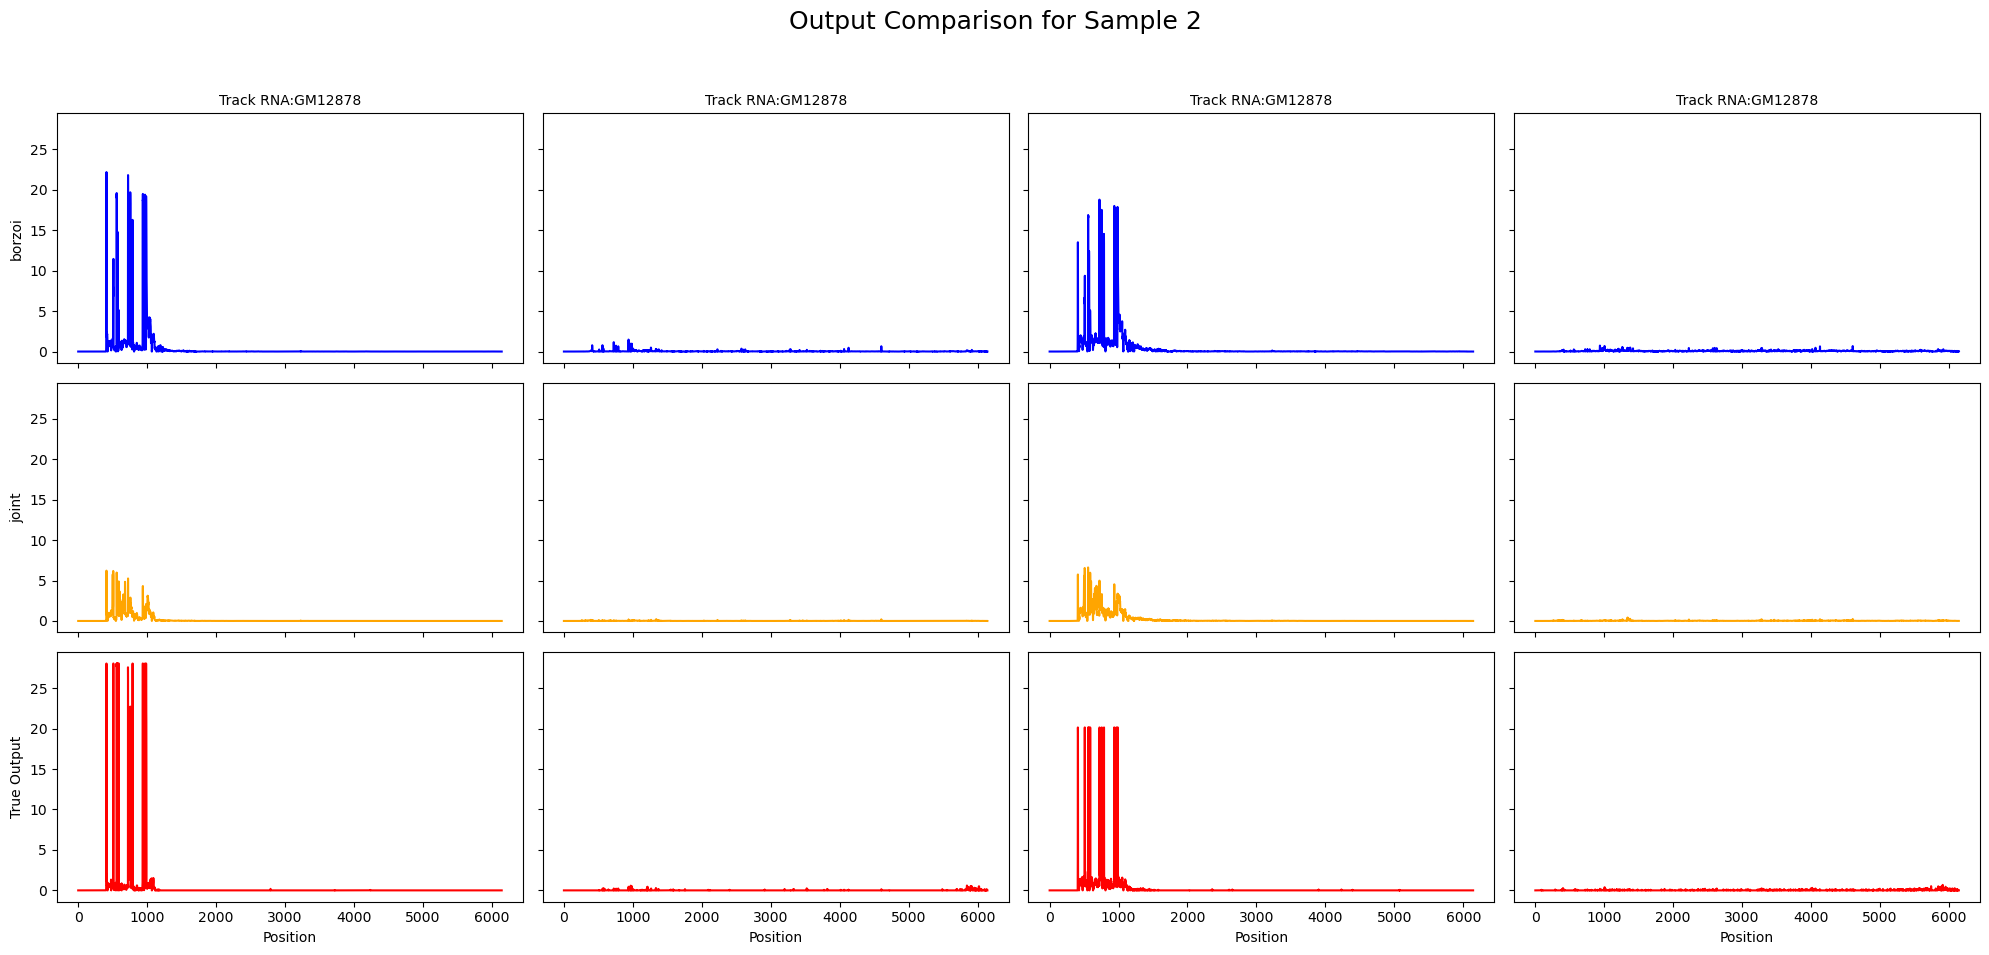

In [70]:
plot_output_tracks(2, borzoi, joint, targets, [4,5,6,7])

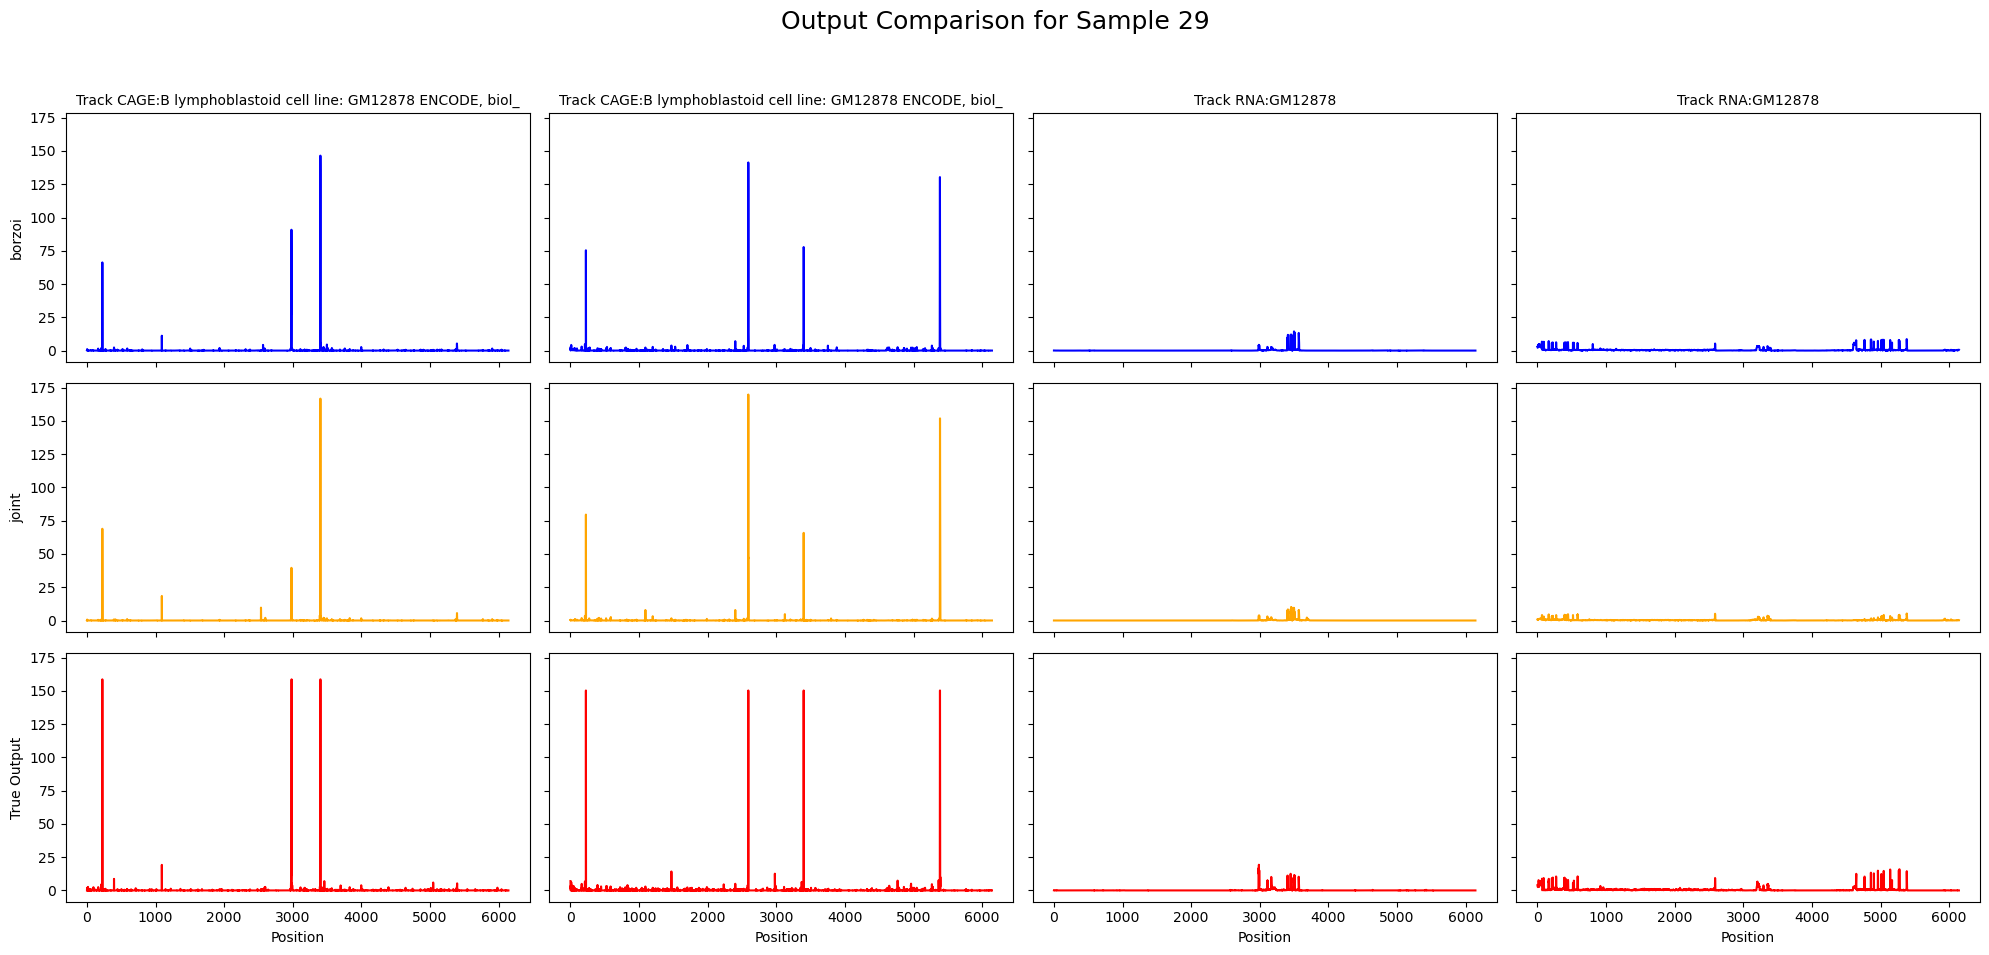

In [73]:
plot_output_tracks(29, borzoi, joint, targets, [0, 1, 2, 3])

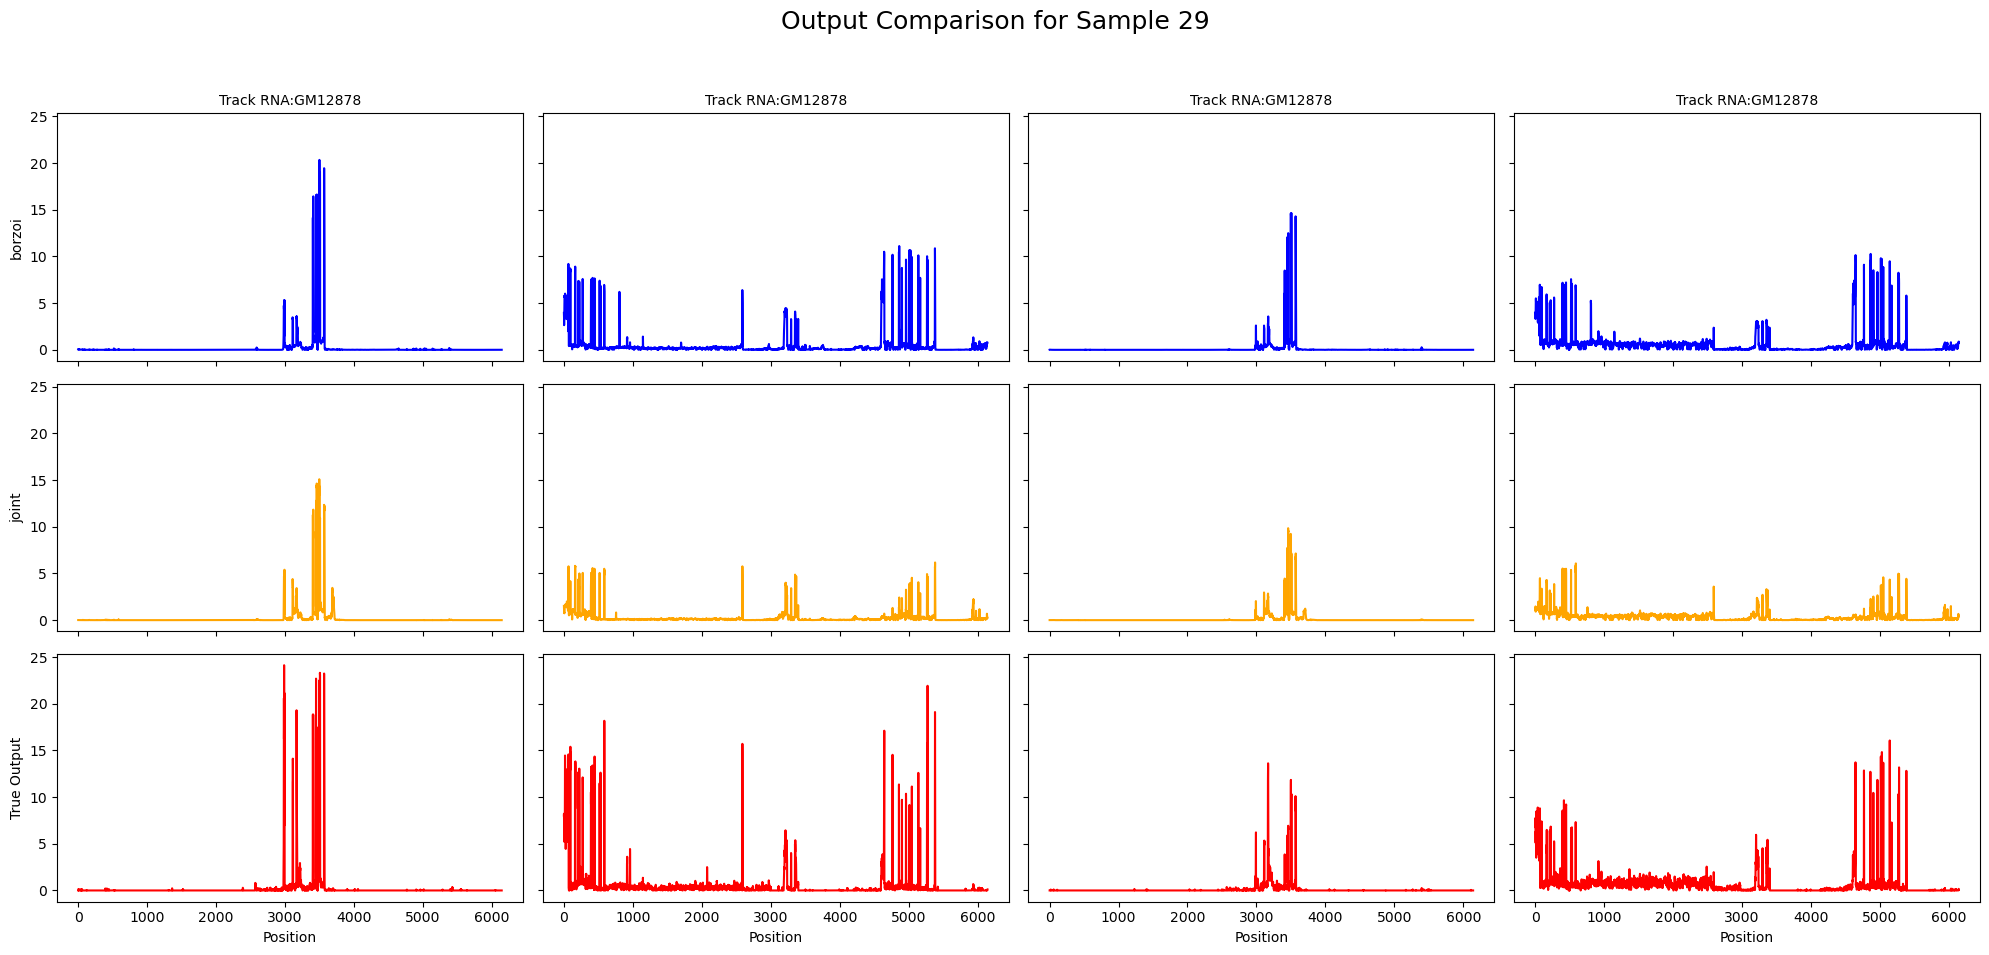

In [75]:
plot_output_tracks(29, borzoi, joint, targets, [4,5,6,7])

In [ ]:
#let's find one where the difference is closer to 0
diff_borzoi = np.abs(borzoi - targets).sum(1)
diff_joint = np.abs(joint - targets).sum(1)
print(diff_borzoi.shape, diff_joint.shape)

In [ ]:
3

# now multiple cell types let's make sure the shapes are right

In [1]:
#I was getting an issue, let's see why?
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
# print(sys.path)
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus
from src.tasks.decoders import EnformerDecoder
from src.tasks.encoders import JointCNN
# from src.tasks.encoders import EnformerEncoder
from caduceus.configuration_caduceus import CaduceusConfig
import torch
import numpy as np
from src.dataloaders.datasets.general_dataset import GeneralDataset
import yaml
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
# import seaborn as sns
from tqdm import tqdm
import argparse
import itertools
import inspect
import zarr
from numcodecs import Blosc
from scipy.stats import spearmanr, pearsonr
from torch.utils.data import DataLoader

#set it so only device 3 is seen

try:
    OmegaConf.register_new_resolver('eval', eval)
    OmegaConf.register_new_resolver('div_up', lambda x, y: (x + y - 1) // y)
except ValueError as e:
    if "Resolver already registered" in str(e):
            print("Resolver already exists, skipping registration.")
            
#edit evals class
class Evals():
    def __init__(self,
                 ckpt_path,
                 dataset=None,
                 split = 'test',
                 device = None,
                 load_data=False,
                 **dataset_overrides #Don't pass None into overrides unless you intentionally want it to be None! Pass in items only that you need
                 ) -> None:
        
        #now load the cfg from the checkpoint path
        model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
        cfg = yaml.load(open(model_cfg_path, 'r'), Loader=yaml.FullLoader)
        cfg = OmegaConf.create(cfg)
        self.cfg = OmegaConf.to_container(cfg, resolve=True)
        
        state_dict = torch.load(ckpt_path, map_location='cpu')
        if device is not None:
            #if we are given a device, we will use that device
            self.device = torch.device(device)
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.split = split

        #now set up dataset
        if dataset is None:
            dataset_args = self.cfg['dataset']
            sig = inspect.signature(GeneralDataset.__init__)
            sig = {k: v for k, v in sig.parameters.items() if k != 'self'}
            to_remove = []
            for k, v in dataset_args.items():
                if k not in sig:
                    # del dataset_args[k]
                    to_remove.append(k)
            for k in to_remove:
                del dataset_args[k]
            dataset_args['split'] = split
            dataset_args['evaluating'] = True #this tells it to not do things like random shifting and rc aug, still does random masking tho, can get og sequence easily
            dataset_args['load_in'] = load_data
            
            for k, v in dataset_overrides.items():
                if k in sig:
                    dataset_args[k] = v
                    print(f"Overriding {k} with {v}")
                else:
                    print(f"Warning: {k} not in dataset args, skipping")
            
            # dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset_args = dataset_args
            # self.dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset = GeneralDataset(**dataset_args)
            
            # self.kmer_len = dataset_args['kmer_len']
            # self.dataset = enformer_dataset.EnformerDataset(split, dataset_args['max_length'], rc_aug = dataset_args['rc_aug'],
            #                                                 return_CAGE=dataset_args['return_CAGE'], cell_type=dataset_args.get('cell_type', None),
            #                                                 kmer_len=dataset_args['kmer_len']) #could use dataloader instead, but again kinda complex
        else:
            self.dataset = dataset
         
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )
        model_state_dict = state_dict["state_dict"]
        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)
        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "decoder" in key:
                decoder_state_dict[key[10:]] = model_state_dict.pop(key)
        encoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "encoder" in key:
                encoder_state_dict[key[10:]] = model_state_dict.pop(key)
        
        cfg['model']['config'].pop('_target_')
        # cfg['model']['config']['complement_map'] = self.dataset.tokenizer.complement_map
        caduceus_cfg = CaduceusConfig(**cfg['model']['config'])
        
        self.backbone = DNAEmbeddingModelCaduceus(config=caduceus_cfg)
        self.backbone.load_state_dict(model_state_dict, strict=True)
        
        #remove self.cfg['decoder']['_name_']
        del self.cfg['decoder']['_name_']
        self.cfg['decoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.decoder = EnformerDecoder(**self.cfg['decoder']) #could do with instantiating, but that is rather complex
        self.decoder.load_state_dict(decoder_state_dict, strict=True)
        
        del self.cfg['encoder']['_name_']
        self.cfg['encoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.encoder = JointCNN(**self.cfg['encoder'])
        self.encoder.load_state_dict(encoder_state_dict, strict=True)
        
        self.encoder.to(self.device).eval()
        self.backbone.to(self.device).eval()
        self.decoder.to(self.device).eval()
        
    def __call__(self, idx=None, data=None):
        #now evaluate the model on one example
        if data is None:
            (seq,acc),(seq_unmask,acc_unmask,exp) = self.dataset[idx]
            
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
        else:
            (x,y),(seq_unmask,acc_unmask,exp) = data

            if x.dim() == 2:
                x = x.unsqueeze(0) #add batch dim
                y = y.unsqueeze(0) #add batch dim
        
        x,y = x.to(self.device), y.to(self.device)
        
        with torch.no_grad():
            x1 = self.encoder(x,y)
            x1,_ = self.backbone(x1)
            x1 = self.decoder(x1)
        
        return x1, exp

In [2]:
ckpt_paths = ['/data1/lesliec/sarthak/caduceus/outputs/2025-04-27/00-18-11-437303/checkpoints/00-val_loss=-0.14044.ckpt']
model_names = ['nobcell_CAGE']
for ckpt_path, model_name in zip(ckpt_paths, model_names):
    break

In [4]:
evals = Evals(ckpt_path, load_data=False, sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
                  data_idxs=None, data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz')

Overriding sequences_bed_file with /data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed
Overriding data_idxs with None
Overriding data_path with /data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


In [ ]:
evals.decoder #output features is 1 as we expect, but it gives us 5 for some reason?

EnformerDecoder(
  (final_pointwise): Sequential(
    (0): Rearrange('b n d -> b d n')
    (1): Sequential(
      (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): GELU()
      (2): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
    )
    (2): Rearrange('b d n -> b n d')
    (3): Dropout(p=0.05, inplace=False)
    (4): GELU()
  )
  (output_transform): Linear(in_features=512, out_features=1, bias=True)
  (pool): AvgPool1d(kernel_size=(128,), stride=(128,), padding=(0,))
  (softplus): Softplus(beta=1, threshold=20)
)

In [5]:
data = evals.dataset[0]

In [6]:
out = evals(0)

In [7]:
out[0].shape

torch.Size([1, 896, 1])

In [8]:
#that's what we expect, so why is the shape giving me issues?
out = evals(data=data)
out[0].shape

torch.Size([1, 896, 1])

In [ ]:
out[1].shape #huh?

(896, 5)

In [ ]:
data[1][2].shape #uh....

(896, 5)

In [ ]:
evals.dataset.additional_data_idxs #ok? Oh, we need to override it. Normally cell types 

array([4759, 4760, 4831, 4764, 4758])

In [ ]:
evals.dataset.celltypes

In [1]:
3

3

In [5]:
evals = Evals(ckpt_path, load_data=False, sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
                  data_idxs=None, data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz', additional_data_idxs=[5110])

Overriding sequences_bed_file with /data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed
Overriding data_idxs with None
Overriding data_path with /data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz
Overriding additional_data_idxs with [5110]
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


In [6]:
out = evals.dataset[0]

In [ ]:
out[1][2].shape #now we're talking!

(896, 1)

# now correlate and compare!

In [1]:
#it was evaluated now let's load it in!
#first we will make sure the targets are the same

import numpy as np
import matplotlib.pyplot as plt
import torch

model_names = ['GM12878_no_mlm_predictions.npy', 'nobcell_CAGE_predictions.npy', 'enformer']
# enformer = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')

preds = {}
for model_name in model_names:
    if model_name == 'enformer':
        preds[model_name] = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')[:, :, 5110]
    else:
        preds[model_name] = np.load(f'/data1/lesliec/sarthak/data/joint_playground/model_out/{model_name}')
    print(preds[model_name].shape)

(1937, 896)
(1937, 896, 1)
(1937, 896)


In [2]:
preds['nobcell_CAGE_predictions.npy'].shape

(1937, 896, 1)

In [3]:
preds['nobcell_CAGE_predictions.npy'] = preds['nobcell_CAGE_predictions.npy'][:,:,0] #just to squeeze it and make it the same shape
preds['nobcell_CAGE_predictions.npy'].shape

(1937, 896)

In [4]:
t1 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_base_targets_conv.npy')
t2 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/nobcell_CAGE_targets.npy')
t1.shape, t2.shape

((1937, 896), (1937, 896, 1))

In [5]:
t2 = t2[:,:,0] #just to squeeze it and make it the same shape

In [ ]:
#now check
np.allclose(t1, t2) #ok this is good!

True

In [7]:
t1

array([[0.        , 0.31152344, 0.        , ..., 0.1652832 , 0.13171387,
        0.        ],
       [0.56835938, 0.05807495, 0.        , ..., 0.        , 0.03143311,
        0.04803467],
       [0.        , 0.        , 0.        , ..., 0.01571655, 0.        ,
        0.0607605 ],
       ...,
       [0.06167603, 0.        , 0.        , ..., 0.        , 0.        ,
        0.31103516],
       [1.78320312, 0.15612793, 1.51074219, ..., 0.        , 0.        ,
        0.        ],
       [0.44970703, 0.        , 0.19482422, ..., 0.0604248 , 0.        ,
        0.        ]])

In [8]:
t2

array([[0.        , 0.31152344, 0.        , ..., 0.1652832 , 0.13171387,
        0.        ],
       [0.56835938, 0.05807495, 0.        , ..., 0.        , 0.03143311,
        0.04803467],
       [0.        , 0.        , 0.        , ..., 0.01571655, 0.        ,
        0.0607605 ],
       ...,
       [0.06167603, 0.        , 0.        , ..., 0.        , 0.        ,
        0.31103516],
       [1.78320312, 0.15612793, 1.51074219, ..., 0.        , 0.        ,
        0.        ],
       [0.44970703, 0.        , 0.19482422, ..., 0.0604248 , 0.        ,
        0.        ]])

In [10]:
#now let's just correlate
from scipy.stats import spearmanr, pearsonr
spearman_results = {}
pearson_results  = {}

for name, arr in preds.items():
    # sanity check: shapes match
    assert arr.shape == t1.shape, f"{name} vs t1 shape mismatch!"
    # loop over samples
    sp = []
    pp = []
    for i in range(arr.shape[0]):
        s = spearmanr(arr[i], t1[i])[0]
        p = pearsonr(arr[i], t1[i])[0]
        sp.append(s)
        pp.append(p)
    spearman_results[name] = np.array(sp)
    pearson_results [name] = np.array(pp)

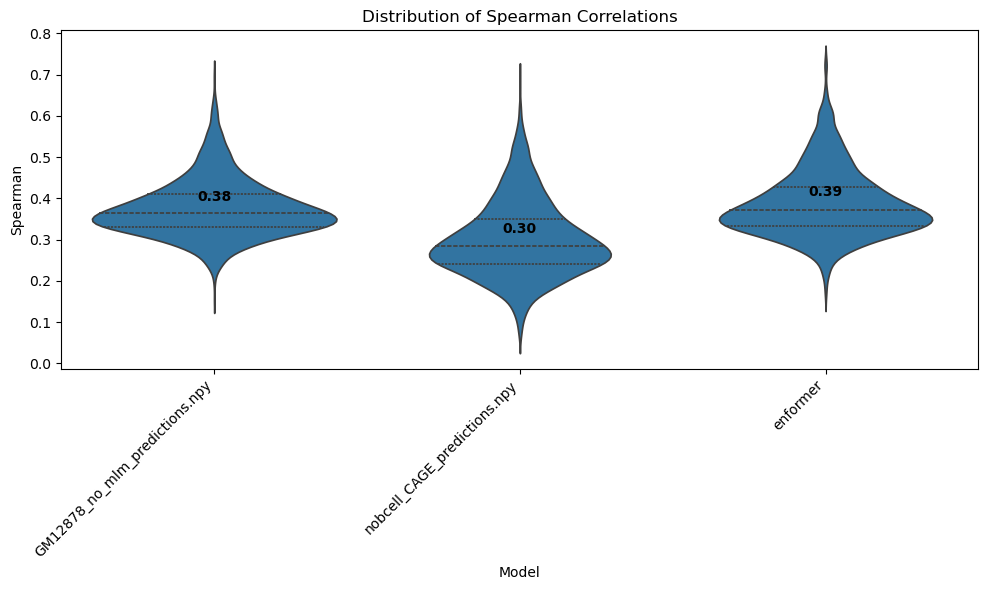

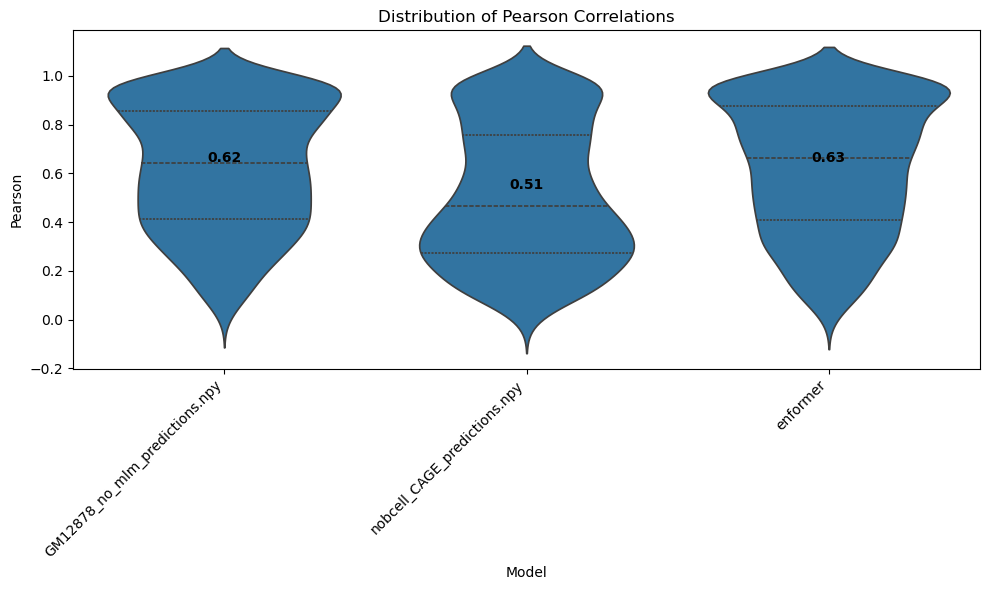

In [12]:
import pandas as pd
import seaborn as sns
df_s = pd.DataFrame(spearman_results)
df_p = pd.DataFrame(pearson_results)

# 3) melt to long form
df_s_long = df_s.melt(var_name="Model", value_name="Spearman")
df_p_long = df_p.melt(var_name="Model", value_name="Pearson")

# 4) plot
for (df_long, metric) in [(df_s_long, "Spearman"), (df_p_long, "Pearson")]:
    plt.figure(figsize=(10, 6))
    ax = sns.violinplot(x="Model", y=metric, data=df_long, inner="quartile")
    plt.xticks(rotation=45, ha="right")
    
    means = df_long.groupby("Model")[metric].mean()

    # Get correct model order from x-tick labels
    xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]

    for idx, model in enumerate(xtick_labels):
        mval = means[model]
        plt.text(idx, mval + 0.01, f"{mval:.2f}",
                 ha="center", va="bottom", weight="semibold")
    
    plt.title(f"Distribution of {metric} Correlations")
    plt.tight_layout()
    plt.show()

# now doing it for more models and also T cells

In [2]:
#first we will load in enformer
import numpy as np
enformer_full = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')
enformer_full.shape

(1937, 896, 5313)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch

model_names = ['GM12878_no_mlm_predictions.npy', 'nobcell_CAGE_predictions.npy', 'immune_CAGE_predictions.npy', 'enformer']
# enformer = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')

preds = {}
for model_name in model_names:
    if model_name == 'enformer':
        preds[model_name] = enformer_full[:, :, 5110]
    else:
        preds[model_name] = np.load(f'/data1/lesliec/sarthak/data/joint_playground/model_out/{model_name}')
        if preds[model_name].ndim == 3:
            preds[model_name] = preds[model_name][:,:,0]
    print(preds[model_name].shape)

(1937, 896)
(1937, 896)
(1937, 896)
(1937, 896)


In [8]:
#now let's make sure the targets are the same
t1 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_base_targets_conv.npy')
t2 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/nobcell_CAGE_targets.npy')[:,:,0]
t3 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/immune_CAGE_targets.npy')[:,:,0]
t1.shape, t2.shape, t3.shape

((1937, 896), (1937, 896), (1937, 896))

In [ ]:
#and now see how similar
print(np.allclose(t1, t2))
print(np.allclose(t1, t3)) #perfect!

True
True


In [10]:
#now let's just correlate
from scipy.stats import spearmanr, pearsonr
spearman_results = {}
pearson_results  = {}

for name, arr in preds.items():
    # sanity check: shapes match
    assert arr.shape == t1.shape, f"{name} vs t1 shape mismatch!"
    # loop over samples
    sp = []
    pp = []
    for i in range(arr.shape[0]):
        s = spearmanr(arr[i], t1[i])[0]
        p = pearsonr(arr[i], t1[i])[0]
        sp.append(s)
        pp.append(p)
    spearman_results[name] = np.array(sp)
    pearson_results [name] = np.array(pp)

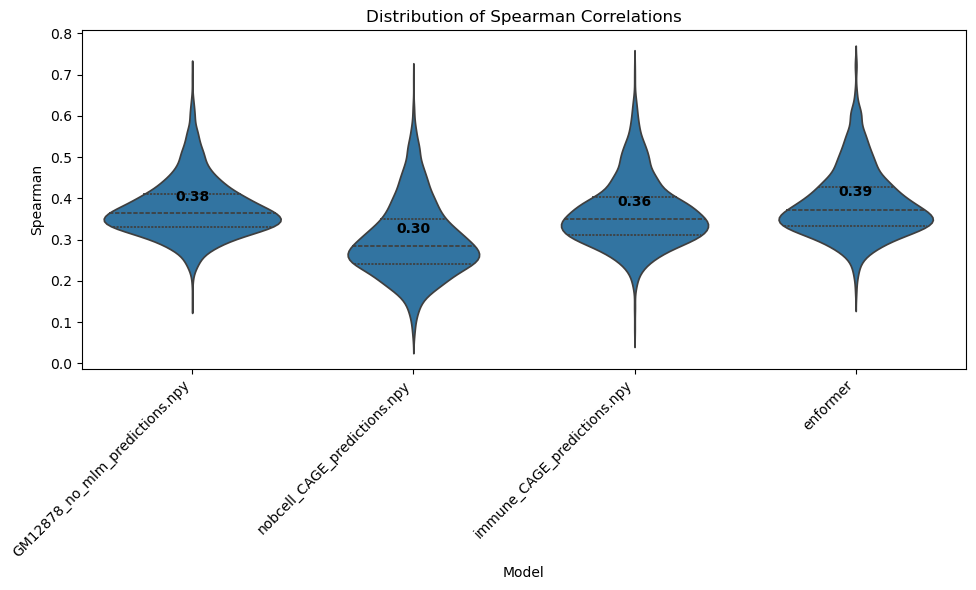

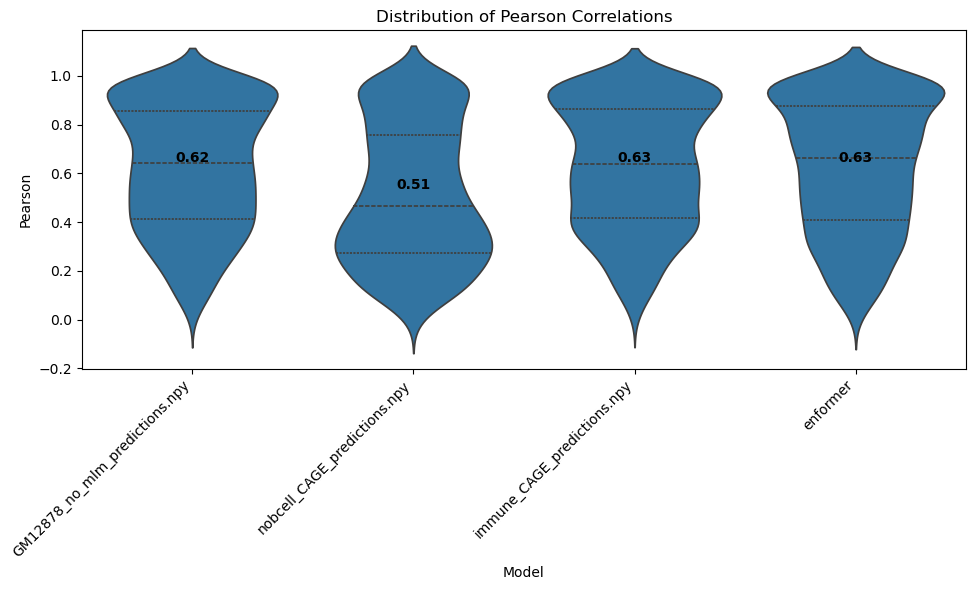

In [11]:
import pandas as pd
import seaborn as sns
df_s = pd.DataFrame(spearman_results)
df_p = pd.DataFrame(pearson_results)

# 3) melt to long form
df_s_long = df_s.melt(var_name="Model", value_name="Spearman")
df_p_long = df_p.melt(var_name="Model", value_name="Pearson")

# 4) plot
for (df_long, metric) in [(df_s_long, "Spearman"), (df_p_long, "Pearson")]:
    plt.figure(figsize=(10, 6))
    ax = sns.violinplot(x="Model", y=metric, data=df_long, inner="quartile")
    plt.xticks(rotation=45, ha="right")
    
    means = df_long.groupby("Model")[metric].mean()

    # Get correct model order from x-tick labels
    xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]

    for idx, model in enumerate(xtick_labels):
        mval = means[model]
        plt.text(idx, mval + 0.01, f"{mval:.2f}",
                 ha="center", va="bottom", weight="semibold")
    
    plt.title(f"Distribution of {metric} Correlations")
    plt.tight_layout()
    plt.show()

In [12]:
#let's redo it on T cells
model_names = ['nobcell_CAGE_CD4T_predictions.npy', 'immune_CAGE_CD4T_predictions.npy', 'enformer']
# enformer = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')

preds = {}
for model_name in model_names:
    if model_name == 'enformer':
        preds[model_name] = enformer_full[:, :, 4759]
    else:
        preds[model_name] = np.load(f'/data1/lesliec/sarthak/data/joint_playground/model_out/{model_name}')
        if preds[model_name].ndim == 3:
            preds[model_name] = preds[model_name][:,:,0]
    print(preds[model_name].shape)

(1937, 896)
(1937, 896)
(1937, 896)


In [13]:
#and get targets
t1 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/nobcell_CAGE_CD4T_targets.npy')[:,:,0]
t2 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/immune_CAGE_CD4T_targets.npy')[:,:,0]
np.allclose(t1, t2) #perfect!

True

In [16]:
#now let's just correlate
from scipy.stats import spearmanr, pearsonr
spearman_results = {}
pearson_results  = {}

for name, arr in preds.items():
    # sanity check: shapes match
    assert arr.shape == t1.shape, f"{name} vs t1 shape mismatch!"
    # loop over samples
    sp = []
    pp = []
    for i in range(arr.shape[0]):
        s = spearmanr(arr[i], t1[i])[0]
        p = pearsonr(arr[i], t1[i])[0]
        sp.append(s)
        pp.append(p)
    spearman_results[name] = np.array(sp)
    pearson_results [name] = np.array(pp)

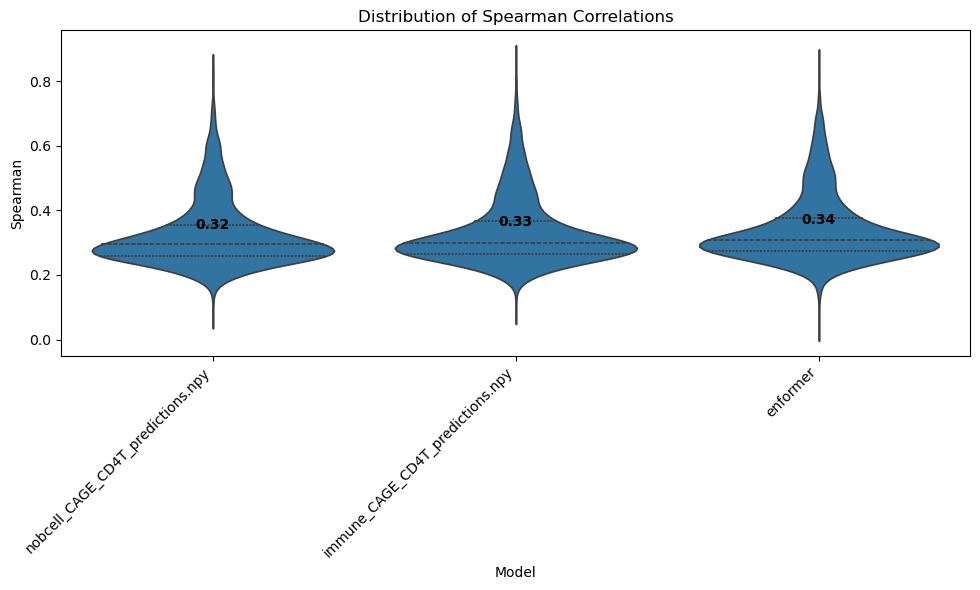

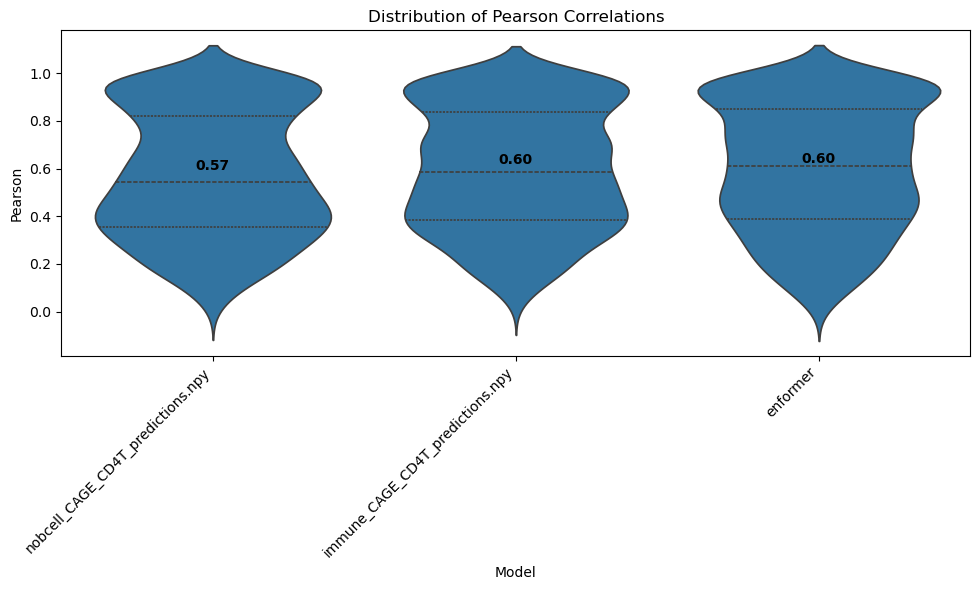

In [17]:
import pandas as pd
import seaborn as sns
df_s = pd.DataFrame(spearman_results)
df_p = pd.DataFrame(pearson_results)

# 3) melt to long form
df_s_long = df_s.melt(var_name="Model", value_name="Spearman")
df_p_long = df_p.melt(var_name="Model", value_name="Pearson")

# 4) plot
for (df_long, metric) in [(df_s_long, "Spearman"), (df_p_long, "Pearson")]:
    plt.figure(figsize=(10, 6))
    ax = sns.violinplot(x="Model", y=metric, data=df_long, inner="quartile")
    plt.xticks(rotation=45, ha="right")
    
    means = df_long.groupby("Model")[metric].mean()

    # Get correct model order from x-tick labels
    xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]

    for idx, model in enumerate(xtick_labels):
        mval = means[model]
        plt.text(idx, mval + 0.01, f"{mval:.2f}",
                 ha="center", va="bottom", weight="semibold")
    
    plt.title(f"Distribution of {metric} Correlations")
    plt.tight_layout()
    plt.show()

# we also did the no pretrain model

In [2]:
#first we will load in enformer
import numpy as np
enformer_full = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')
enformer_full.shape
import numpy as np
import matplotlib.pyplot as plt
import torch

model_names = ['GM12878_no_mlm_predictions.npy', 'nobcell_CAGE_predictions.npy', 'immune_CAGE_predictions.npy', 'nopretrain_predictions.npy', 'enformer']
# enformer = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')

preds = {}
for model_name in model_names:
    if model_name == 'enformer':
        preds[model_name] = enformer_full[:, :, 5110]
    else:
        preds[model_name] = np.load(f'/data1/lesliec/sarthak/data/joint_playground/model_out/{model_name}')
        if preds[model_name].ndim == 3:
            preds[model_name] = preds[model_name][:,:,0]
    print(preds[model_name].shape)
#now let's make sure the targets are the same
t1 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_base_targets_conv.npy')
t2 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/nobcell_CAGE_targets.npy')[:,:,0]
t3 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/immune_CAGE_targets.npy')[:,:,0]
t1.shape, t2.shape, t3.shape
#and now see how similar
print(np.allclose(t1, t2))
print(np.allclose(t1, t3)) #perfect!
#now let's just correlate
from scipy.stats import spearmanr, pearsonr
spearman_results = {}
pearson_results  = {}

for name, arr in preds.items():
    # sanity check: shapes match
    assert arr.shape == t1.shape, f"{name} vs t1 shape mismatch!"
    # loop over samples
    sp = []
    pp = []
    for i in range(arr.shape[0]):
        s = spearmanr(arr[i], t1[i])[0]
        p = pearsonr(arr[i], t1[i])[0]
        sp.append(s)
        pp.append(p)
    spearman_results[name] = np.array(sp)
    pearson_results [name] = np.array(pp)

(1937, 896)
(1937, 896)
(1937, 896)
(1937, 896)
(1937, 896)
True
True


In [4]:
#let's also quickly verify the no pretrain targets are correct
t1 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/nopretrain_targets.npy')[:,:,0]
#and load in the base as comparison
t2 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_base_targets_conv.npy')
t1.shape, t2.shape, np.allclose(t1, t2) #perfect!

((1937, 896), (1937, 896), True)

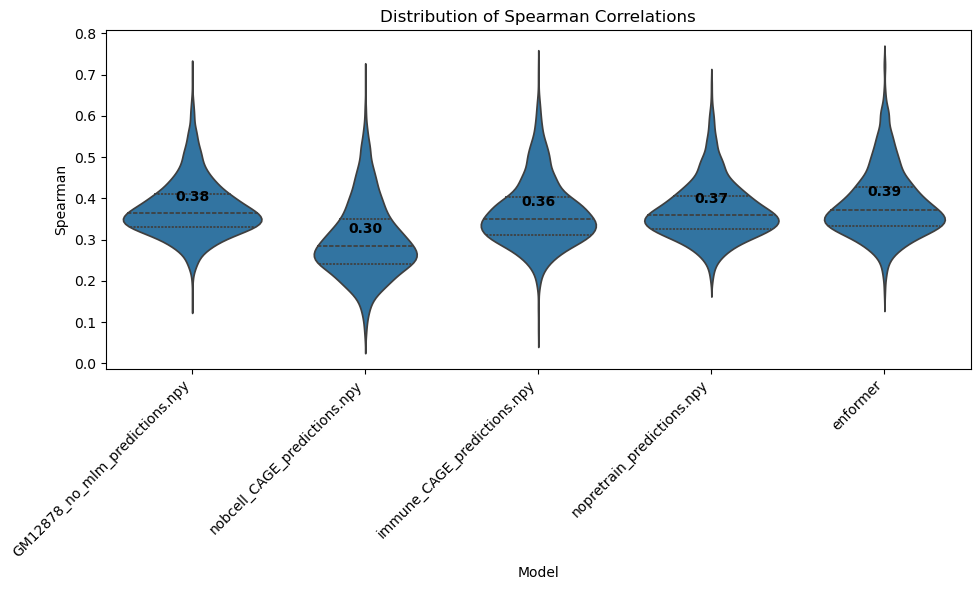

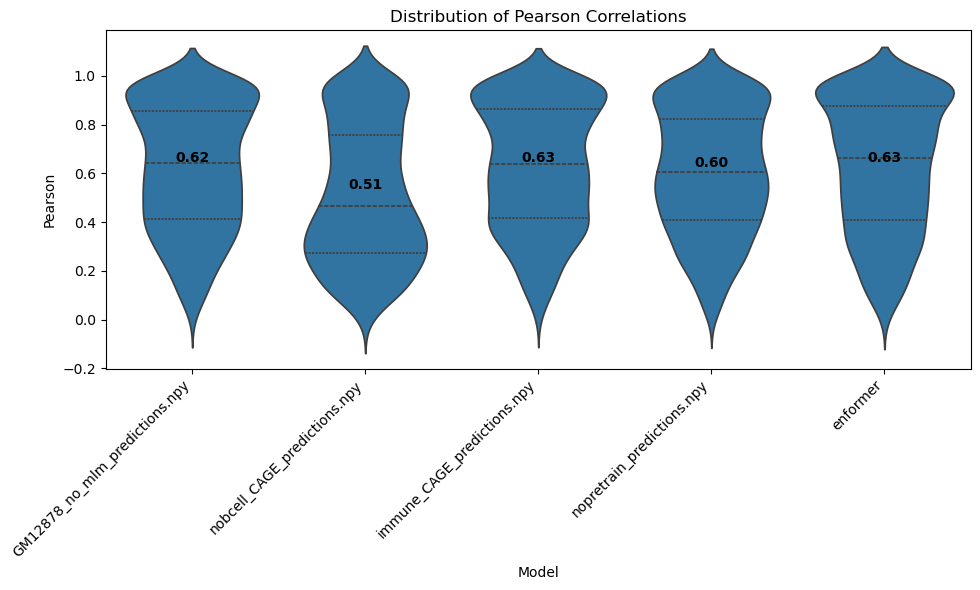

In [5]:
import pandas as pd
import seaborn as sns
df_s = pd.DataFrame(spearman_results)
df_p = pd.DataFrame(pearson_results)

# 3) melt to long form
df_s_long = df_s.melt(var_name="Model", value_name="Spearman")
df_p_long = df_p.melt(var_name="Model", value_name="Pearson")

# 4) plot
for (df_long, metric) in [(df_s_long, "Spearman"), (df_p_long, "Pearson")]:
    plt.figure(figsize=(10, 6))
    ax = sns.violinplot(x="Model", y=metric, data=df_long, inner="quartile")
    plt.xticks(rotation=45, ha="right")
    
    means = df_long.groupby("Model")[metric].mean()

    # Get correct model order from x-tick labels
    xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]

    for idx, model in enumerate(xtick_labels):
        mval = means[model]
        plt.text(idx, mval + 0.01, f"{mval:.2f}",
                 ha="center", va="bottom", weight="semibold")
    
    plt.title(f"Distribution of {metric} Correlations")
    plt.tight_layout()
    plt.show()

In [ ]:
#hmm, seems that pretraining is not really all that helpful